In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'figure.figsize':(20,10), 'figure.dpi':120})

from sklearn.metrics import root_mean_squared_error,mean_absolute_percentage_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

from src.ETL import *
from src.backtesting_forecasting import *

ROOT_PATH = 'data'

## Target series analysis

Index(['HPI', 'HPI_real', 'HPI_growth1_real', 'HPI_growth1_real_lag_1',
       'HPI_growth1_real_lag_2', 'HPI_growth1_real_lag_3',
       'HPI_growth1_real_lag_4', 'HPI_growth1_real_lag_5',
       'HPI_growth1_real_lag_6', 'HPI_growth1_real_lag_7'],
      dtype='object')


<Axes: xlabel='Date'>

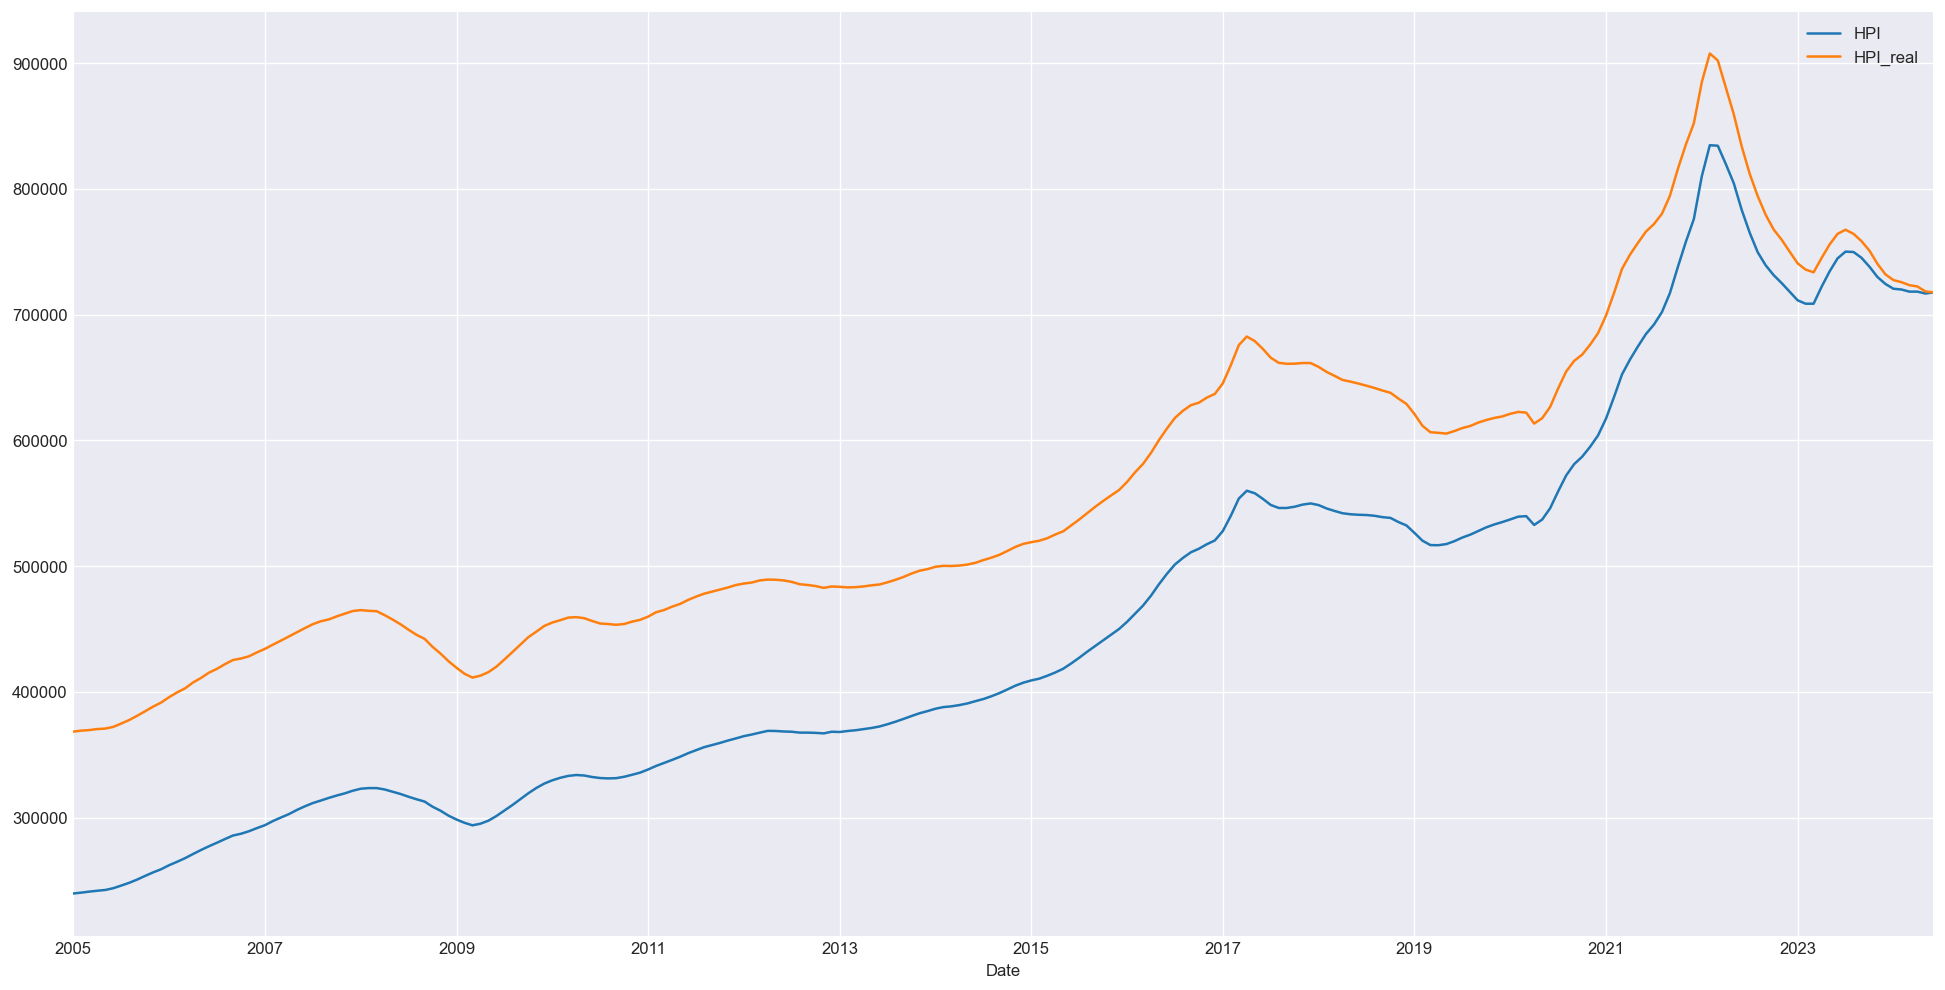

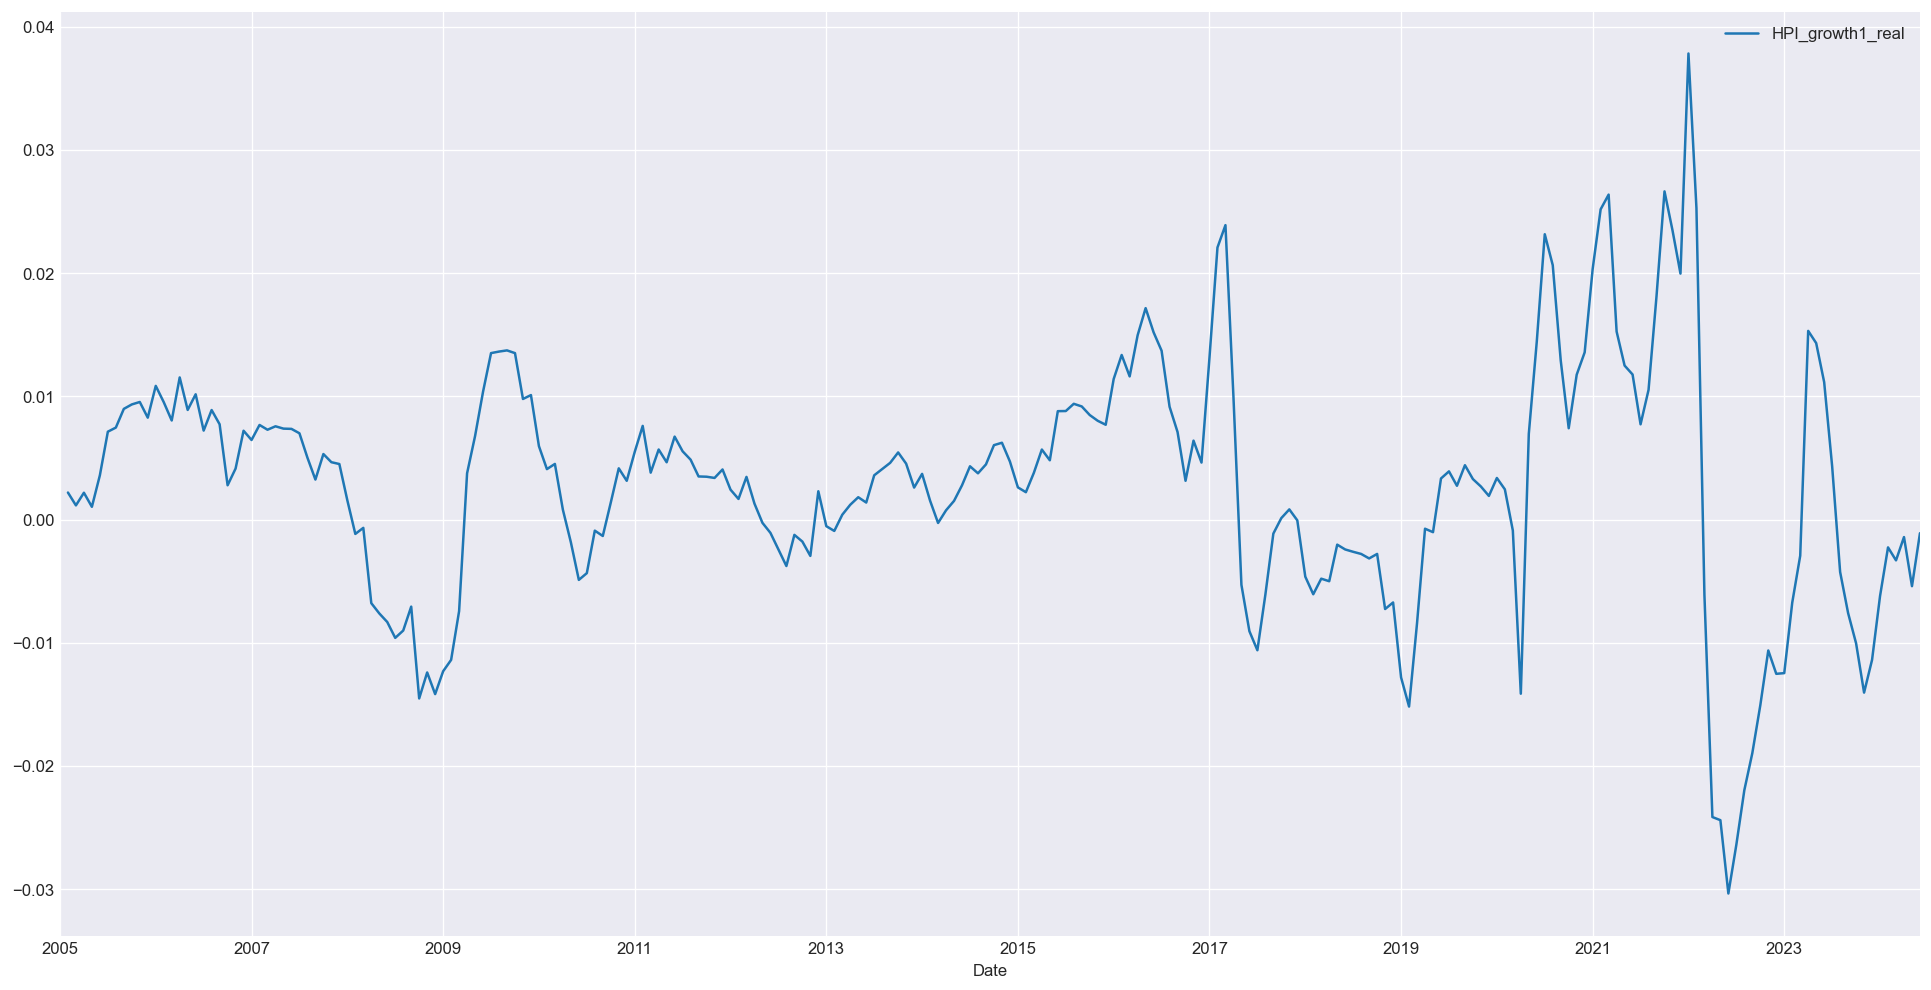

In [2]:
cpi = etl_pipeline(extract_data_from_StatsCanada, file_path = f'{ROOT_PATH}/1810025601_databaseLoadingData.csv', 
                    in_col = "Alternative measures",
                    out_cols = ["Measure of core inflation based on a weighted median approach, CPI-median (index, 198901=100)"],
                    new_names = ['CPI'],
                    num_lags = 1)

df = etl_pipeline(extract_data_from_CREA, file_path = f'{ROOT_PATH}/MLS_HPI/Seasonally Adjusted_June_2024.xlsx', sheet_name = 'AGGREGATE',
                in_col = "Composite_Benchmark_SA", new_names = ["HPI"],
                num_lags = 7, lagged_cols = ['HPI_growth1_real'],
                transform_dict = {"HPI": [infl_adjusted(cpi), compose(growth(1), infl_adjusted(cpi))]})


print(df.columns)

target = "HPI_growth1_real" 
# df = df[target].dropna()
# df.plot()
df[['HPI','HPI_real']].plot()
plt.figure()
df[target].plot(legend="top")

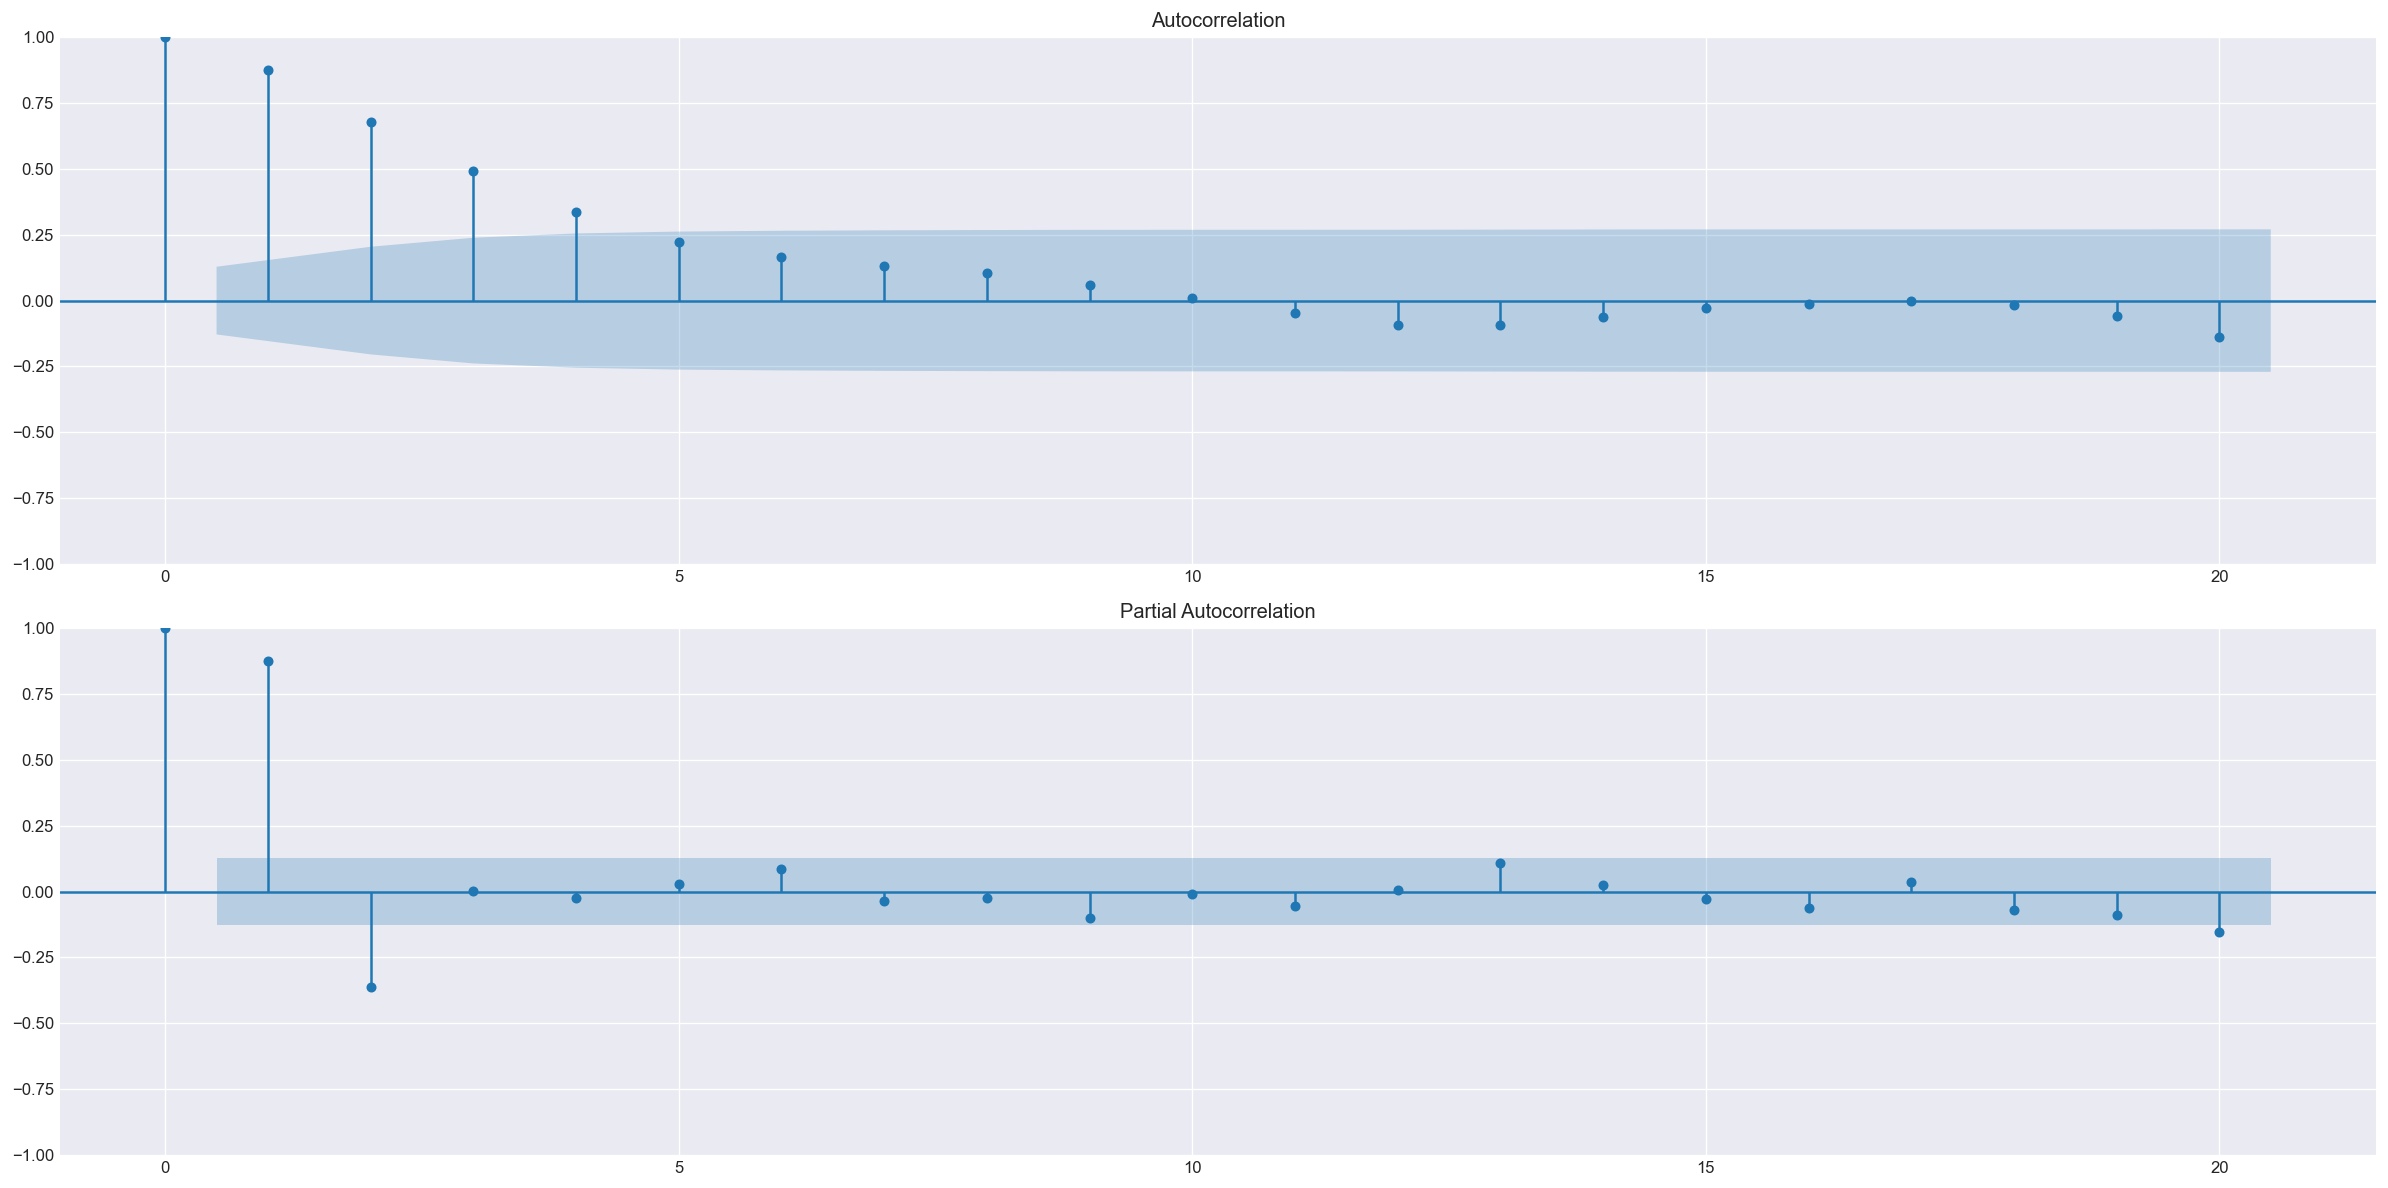

In [3]:
f, ax = plt.subplots(nrows=2, ncols=1)
plot_acf(df[target].dropna(),lags=20, ax=ax[0])
plot_pacf(df[target].dropna(),lags=20, ax=ax[1])
plt.tight_layout()
plt.show()

## Covariates engineering

In [4]:

df_cov = df.join(etl_pipeline(extract_data_from_StatsCanada, file_path = f'{ROOT_PATH}/1410028701_databaseLoadingData.csv',
                            in_col = "Labour force characteristics", 
                            out_cols = ["Participation rate", "Employment rate", "Unemployment rate","Population", "Labour force",]
                            ))

df_cov = df_cov.join(etl_pipeline(extract_data_from_StatsCanada, file_path = f'{ROOT_PATH}/3410014501_databaseLoadingData.csv', in_col = None, out_cols = ["Mortgage rate 5y"],
                         transform_dict = {"Mortgage rate 5y": [diff(1), diff(12), growth(1), growth(12),rolling_mean(3),compose(growth(12),rolling_mean(3)),
                                                                compose(growth(1),rolling_mean(3))]
                                          }))

df_cov = df_cov.join(etl_pipeline(extract_data_from_StatsCanada, file_path = f'{ROOT_PATH}/1810020501_databaseLoadingData.csv', 
                                     in_col = "New housing price indexes",
                                     out_cols = ["Total (house and land)"],
                                     new_names = ["NHPI"],
                                     transform_dict = {"NHPI": compose(growth(1), infl_adjusted(cpi)) }))


df_cov = df_cov.join(etl_pipeline(extract_data_from_StatsCanada, file_path = f'{ROOT_PATH}/1010011601_databaseLoadingData.csv', 
                                     in_col = "Assets, liabilities and monetary aggregates",
                                     out_cols = ["M2 (gross) (currency outside banks, chartered bank demand and notice deposits, chartered bank personal term deposits, adjustments to M2 (gross) (continuity adjustments and inter-bank demand and notice deposits))",
                                      "M2++ (gross) (M2+ (gross), Canada Savings Bonds, non-money market mutual funds)"],
                                     new_names = ["M2", "M2++"],
                                     transform_dict = {"M2": [infl_adjusted(cpi), compose(growth(1), infl_adjusted(cpi)),compose(growth(12), infl_adjusted(cpi))],
                                                       "M2++": [compose(growth(12), infl_adjusted(cpi)),
                                                                compose(growth(1), infl_adjusted(cpi)), 
                                                                ]}))
# df_cov = df_cov.join(etl_pipeline(extract_data_from_StatsCanada, file_path = f'{ROOT_PATH}/3410013501_databaseLoadingData.csv', 
#                                      in_col = "Housing estimates",
#                                      out_cols = ["Housing starts","Housing under construction", "Housing completions" ],
#                                      filters = {"Type of unit": "Total units"},
#                                      transform_dict = {"Housing completions": growth(4),
#                                                        "Housing starts": growth(4),
#                                                        "Housing under construction": growth(4)}))

# df_cov = df_cov.join(etl_pipeline(extract_data_from_StatsCanada, file_path = f'{ROOT_PATH}/3610011201_databaseLoadingData.csv', 
#                                     in_col = "Estimates",
#                                     out_cols = ["Equals: household disposable income","Compensation of employees", "Household saving rate"],
#                                     new_names = ["Disposable income","Compensation", "Household saving rate"],
#                                     transform_dict = {"Disposable income": compose(growth(1), infl_adjusted(cpi)),
#                                                       "Compensation": compose(growth(1), infl_adjusted(cpi)),
#                                                       "Household saving rate": rolling_mean(3)}))

# df_cov = df_cov.join(etl_pipeline(extract_data_from_StatsCanada, file_path = f'{ROOT_PATH}/3610049101_databaseLoadingData.csv', 
#                                       in_col = "North American Industry Classification System (NAICS)",
#                                       out_cols = ["All industries [T001]"], 
#                                       new_names = ["GDP"],
#                                       filters = {"Release": "May 31, 2024"},
#                                       transform_dict = {"GDP": growth(12)}))

df_cov = df_cov.join(etl_pipeline(extract_data_from_CREA, file_path = f'{ROOT_PATH}/News_release_chart_data_May_2024.xlsx', sheet_name="Chart A",
                      in_col = ["Canada"],
                      new_names = ["Sales"],))

df_cov = df_cov.ffill().bfill()
df_cov = df_cov[sorted(df_cov.columns)]

# df_cov

corr_lag = df_cov.corr()[target][df_cov.corr()[target].abs()>0.3].sort_values()
df_cov.corr()

/Users/andreypak/Downloads/Canada HPI forecasting/src/ETL.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}"] = df[col].shift(lag)
/Users/andreypak/Downloads/Canada HPI forecasting/src/ETL.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}"] = df[col].shift(lag)
/Users/andreypak/Downloads/Canada HPI forecasting/src/ETL.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

Employment rate  Employment rate_lag_1  \
Employment rate                 1.000000               0.903674   
Employment rate_lag_1           0.903674               1.000000   
Employment rate_lag_10          0.388130               0.428026   
Employment rate_lag_11          0.356258               0.390074   
Employment rate_lag_12          0.345211               0.358694   
...                                  ...                    ...   
Unemployment rate_lag_5        -0.236745              -0.288431   
Unemployment rate_lag_6        -0.199334              -0.238489   
Unemployment rate_lag_7        -0.172753              -0.200436   
Unemployment rate_lag_8        -0.155631              -0.174778   
Unemployment rate_lag_9        -0.129207              -0.157552   

                         Employment rate_lag_10  Employment rate_lag_11  \
Employment rate                        0.388130                0.356258   
Employment rate_lag_1                  0.428026                0.390074   
Employment rate_lag_10                 1.000000                0.906403   
Employment rate_lag_11                 0.906403                1.000000   
Employment rate_lag_12                 0.758298                0.906779   
...                                         ...                     ...   
Unemployment rate_lag_5               -0.287528               -0.241067   
Unemployment rate_lag_6               -0.337624               -0.288396   
Unemployment rate_lag_7               -0.410179               -0.337628   
Unemployment rate_lag_8               -0.516126               -0.411285   
Unemployment rate_lag_9               -0.644433               -0.517187   

                         Employment rate_lag_12  Employment rate_lag_13  \
Employment rate                        0.345211                0.328780   
Employment rate_lag_1                  0.358694                0.347604   
Employment rate_lag_10                 0.758298                0.658649   
Employment rate_lag_11                 0.906779                0.759138   
Employment rate_lag_12                 1.000000                0.907070   
...                                         ...                     ...   
Unemployment rate_lag_5               -0.197074               -0.163404   
Unemployment rate_lag_6               -0.240280               -0.196932   
Unemployment rate_lag_7               -0.286693               -0.239146   
Unemployment rate_lag_8               -0.336901               -0.286639   
Unemployment rate_lag_9               -0.410347               -0.336614   

                         Employment rate_lag_2  Employment rate_lag_3  \
Employment rate                       0.750999               0.648103   
Employment rate_lag_1                 0.903966               0.751665   
Employment rate_lag_10                0.451660               0.470345   
Employment rate_lag_11                0.429740               0.453387   
Employment rate_lag_12                0.392201               0.431822   
...                                        ...                    ...   
Unemployment rate_lag_5              -0.355987              -0.452256   
Unemployment rate_lag_6              -0.289435              -0.357429   
Unemployment rate_lag_7              -0.238819              -0.290248   
Unemployment rate_lag_8              -0.201662              -0.240533   
Unemployment rate_lag_9              -0.175833              -0.203252   

                         Employment rate_lag_4  Employment rate_lag_5  ...  \
Employment rate                       0.579809               0.529721  ...   
Employment rate_lag_1                 0.649041               0.580990  ...   
Employment rate_lag_10                0.498091               0.537045  ...   
Employment rate_lag_11                0.471728               0.499661  ...   
Employment rate_lag_12                0.455032               0.473542  ...   
...                                        ...                    ...  ..

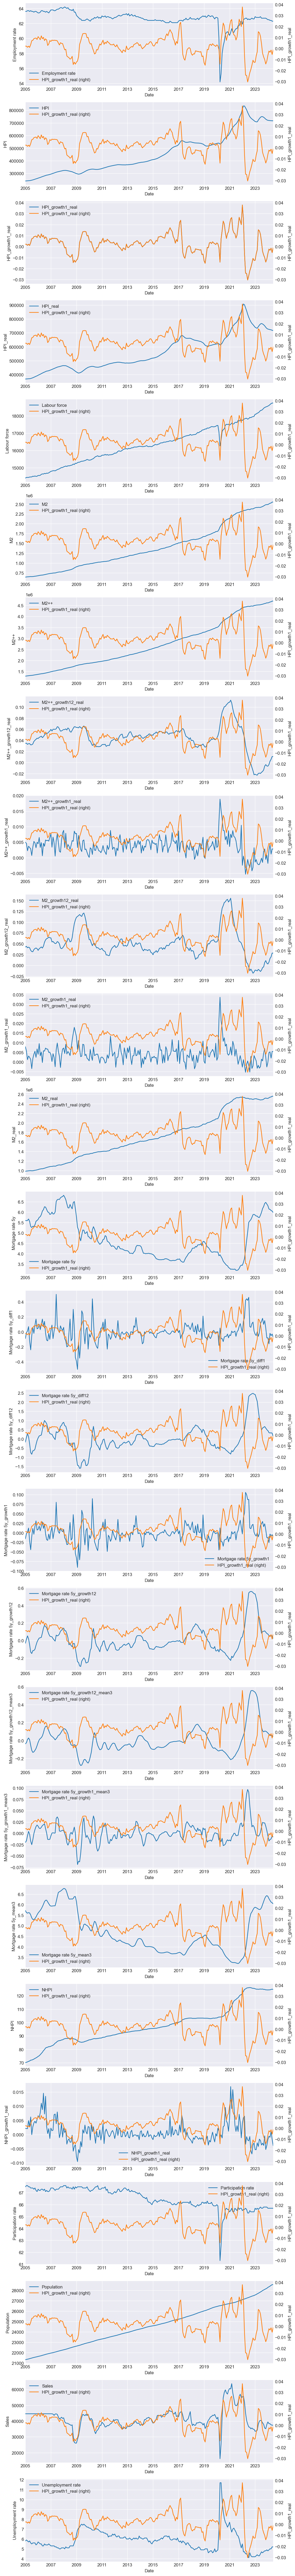

In [5]:
def plot_covariates(df, target, features = None):
    if not features:
        features = [col for col in df.columns if "lag" not in col]
    n_rows = len(features)
    fig, ax = plt.subplots(n_rows, 1, figsize=(10, 4*n_rows))
    for i,feature in enumerate(features):
        df[feature].plot(ylabel=feature, ax=ax[i], legend="left")
        df[target].plot(secondary_y=True, ylabel=target, ax=ax[i], legend="left")
plot_covariates(df_cov, target)
# plot_covariates(df_cov, target, ["Mortgage rate 5y_growth12", "M2++_growth12_real"])

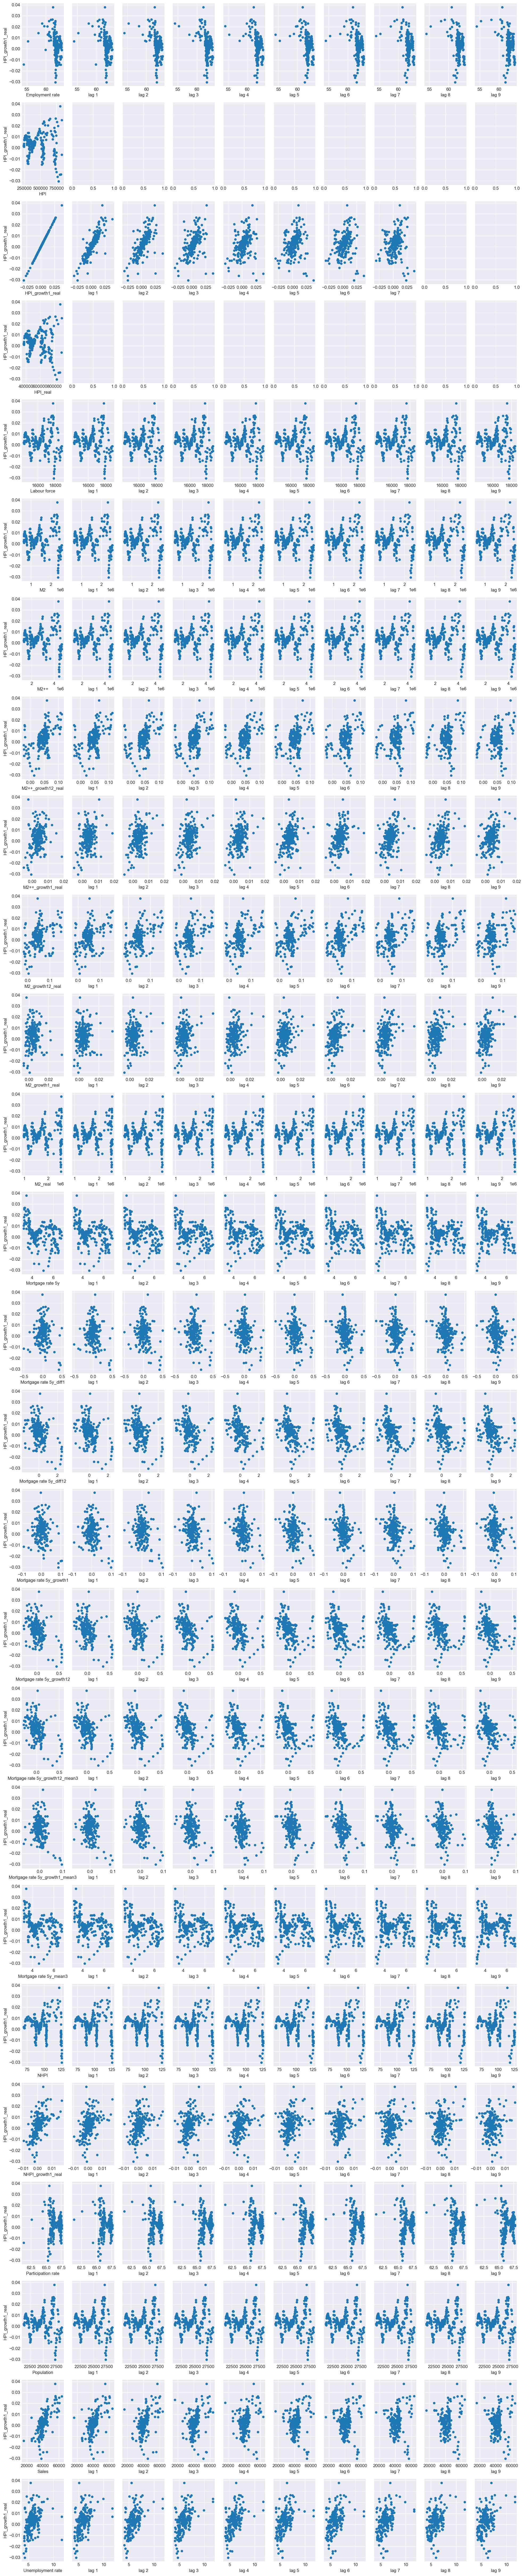

In [6]:
def plot_target_covariates(df, num_lags, target, features = None):
    if not features:
        features = [col for col in df.columns if "lag" not in col]
    n_rows = len(features)
    fig, ax = plt.subplots(n_rows, num_lags, sharey="row", figsize=(20,4*n_rows))
    for i, feature in enumerate(features):
        for j in range(num_lags):
            col_name  = feature if j==0 else feature + "_lag_" + str(j)
            if col_name in df.columns:
                df.plot.scatter(col_name, target, ax=ax[i][j])
                ax[i][j].set_xlabel(feature if j==0 else "lag " + str(j))
    
plot_target_covariates(df_cov, 10, target)
# plot_target_covariates(df_cov,7,target, ["Mortgage rate 5y_growth12", "M2++_growth1_real"])

In [5]:
pd.set_option('display.max_rows', None)
print(corr_lag)
# print(df_cov.corr()["Mortgage rate 5y_growth12"][df_cov.corr()["Mortgage rate 5y_growth12"].abs()>0.3].sort_values())
pd.reset_option('display.max_rows')

Mortgage rate 5y_growth12               -0.487898
Mortgage rate 5y_growth12_mean3         -0.487825
Mortgage rate 5y_growth12_lag_1         -0.482801
Mortgage rate 5y_growth12_mean3_lag_1   -0.472347
Mortgage rate 5y_growth12_lag_2         -0.467148
Mortgage rate 5y_growth12_mean3_lag_2   -0.450887
Mortgage rate 5y_growth12_lag_3         -0.442528
Mortgage rate 5y_diff12                 -0.433953
Mortgage rate 5y_diff12_lag_1           -0.431601
Mortgage rate 5y_growth12_mean3_lag_3   -0.428370
Mortgage rate 5y_growth12_lag_4         -0.420439
Mortgage rate 5y_diff12_lag_2           -0.420304
Mortgage rate 5y_growth12_mean3_lag_4   -0.405783
Mortgage rate 5y_growth12_lag_5         -0.401900
Mortgage rate 5y_diff12_lag_3           -0.400319
Mortgage rate 5y_growth1_mean3_lag_4    -0.390156
Mortgage rate 5y_growth1_mean3_lag_5    -0.384907
Mortgage rate 5y_growth12_mean3_lag_5   -0.383606
Mortgage rate 5y_growth1_mean3_lag_3    -0.381690
Mortgage rate 5y_diff12_lag_4           -0.381360


## Forecasting and Backtesting utils

In [6]:
# Custom Moving Average model class
class MovingAverage:
    def __init__(self, y_lags):
        """
        Initialize the MovingAverage model with a specified number of lags.
        
        Parameters:
        - y_lags (int): The number of lags to consider for the moving average.
        """
        self.y_lags = y_lags
    
    def fit(self, X, y):
        """
        Fit method (placeholder) for compatibility with scikit-learn interface.
        
        Parameters:
        - X (array-like): Features (not used in this model).
        - y (array-like): Target variable (not used in this model).
        """
        pass
    
    def predict(self, y):
        """
        Predict the next value based on the moving average of the last y_lags values.
        
        Parameters:
        - y (array-like): Array of values to calculate the moving average from.
        
        Returns:
        - list: A list containing the predicted value.
        """
        return [np.mean(y[0][:self.y_lags])]

# Instantiate the MovingAverage model
MA = MovingAverage(y_lags=1)

def inv_growth(dy, y0):
    """
    Reverts the growth rate to actual values.
    
    Parameters:
    - dy (array-like): The growth rate series.
    - y0 (float): The initial value.
    
    Returns:
    - np.array: The reverted series.
    """
    return np.exp(np.cumsum(dy)) * y0

def maape(A, F):
    return np.mean(np.arctan(np.abs((F - A) / A)))

def calc_metrics(y, y_hat, interval_name):
    """
    Calculate and print various performance metrics for the model.
    
    Parameters:
    - y (array-like): The true values.
    - y_hat (array-like): The predicted values.
    - y_train (array-like): The training target values.
    - interval_name (str): The name of the interval (e.g., 'Train', 'Test').
    """
    print(f"--------------{interval_name}-------------------")
    print(f"RMSE: {root_mean_squared_error(y, y_hat):.3f}", )
    print(f"R^2:  {r2_score(y, y_hat):.2f}", )
    print(f"MAAPE:  {maape(y, y_hat):.2f}", )


def show_results(y, preds, test_split_time, inverse_transform=False):
    """
    Display and compare actual vs predicted values, and calculate performance metrics.
    
    Parameters:
    - y (pd.Series): The true target series.
    - preds (array-like): The predicted values.
    - test_split_time (str or pd.Timestamp): The split time separating train and test periods.
    - inverse_transform (bool): Whether to apply inverse transformations to predictions.
    """
    y_train, y_test = y[:test_split_time], y[test_split_time:]

    if inverse_transform:
        preds = inv_growth(preds, y_train.iloc[0])

    preds = pd.Series(preds, name="Predictions", index=y.index)
    figure = plt.figure()
    y.plot(legend="top")
    preds.plot(legend="top")
    calc_metrics(y_train, preds[:test_split_time], "Train")
    calc_metrics(y_test, preds[test_split_time:],"Test")

def show_backteting(series_args, y, inverse_transform=False):
    
    for series, series_name in series_args:
        rmse_l, maape_l = [] ,[]
        figure = plt.figure()
        y.plot(legend="top")

        for y_hat in series:
            ind = y_hat.index
            if inverse_transform:
                y_hat = inv_growth(y_hat, y[:ind[0]].iloc[-2])
            rmse_l.append(root_mean_squared_error(y[ind], y_hat))
            maape_l.append(maape(y[ind], y_hat))

            y_hat.plot(label=series_name, color = 'red')
        print(f"----------{series_name}---------")
        print(f"avg RMSE: {np.mean(rmse_l):.3f}", )
        print(f"avg MAAPE: {np.mean(maape_l):.2f}", )    

## Linear Regression

coefficients:  -0.00020709316453233631 [-0.29001052  1.08592131 -0.00473332  0.20066368]
--------------Train-------------------
RMSE: 0.003
R^2:  0.79
MAAPE:  0.41
--------------Test-------------------
RMSE: 0.008
R^2:  0.78
MAAPE:  0.40
--------------Train-------------------
RMSE: 7403.345
R^2:  0.99
MAAPE:  0.01
--------------Test-------------------
RMSE: 12437.107
R^2:  0.95
MAAPE:  0.01
----------Backtesting---------
avg RMSE: 0.012
avg MAAPE: 0.53
----------Naive---------
avg RMSE: 0.014
avg MAAPE: 0.61
----------Backtesting---------
avg RMSE: 24918.969
avg MAAPE: 0.02
----------Naive---------
avg RMSE: 28681.536
avg MAAPE: 0.03
                            OLS Regression Results                            
Dep. Variable:       HPI_growth1_real   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     185.5
Date:                Thu, 15 Aug 2024   Pr

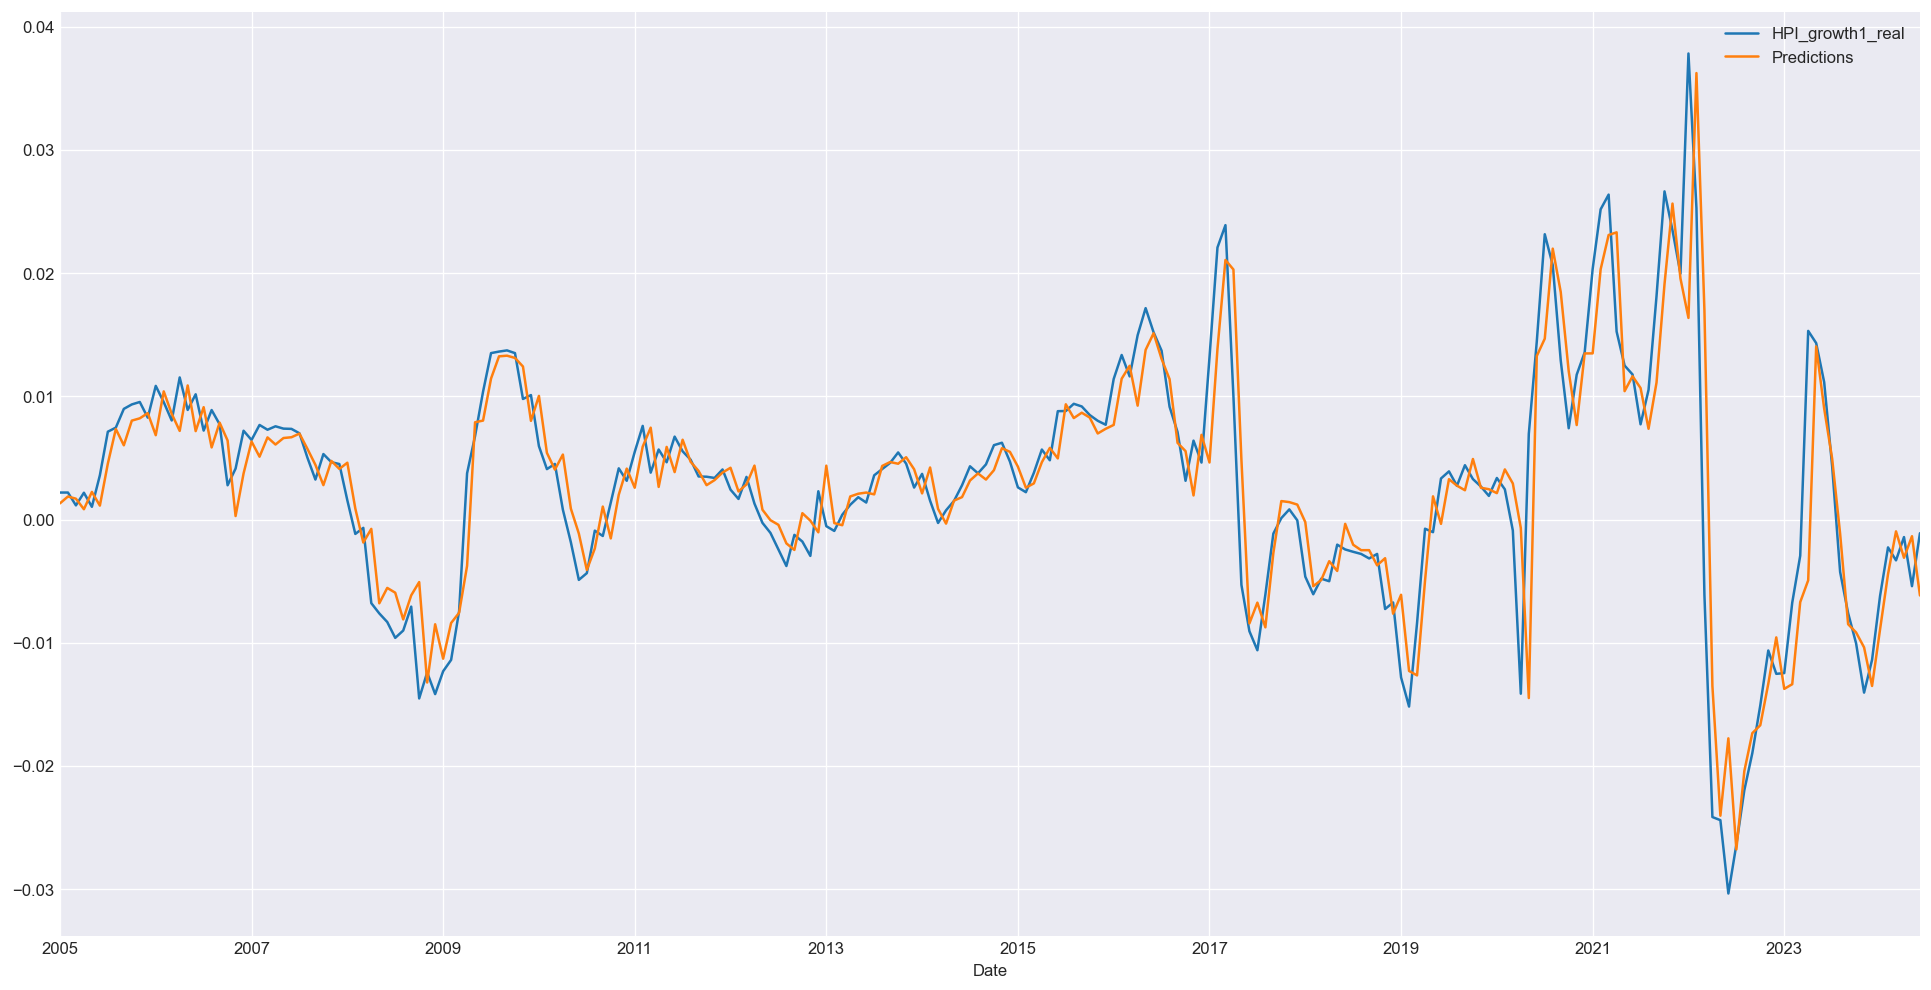

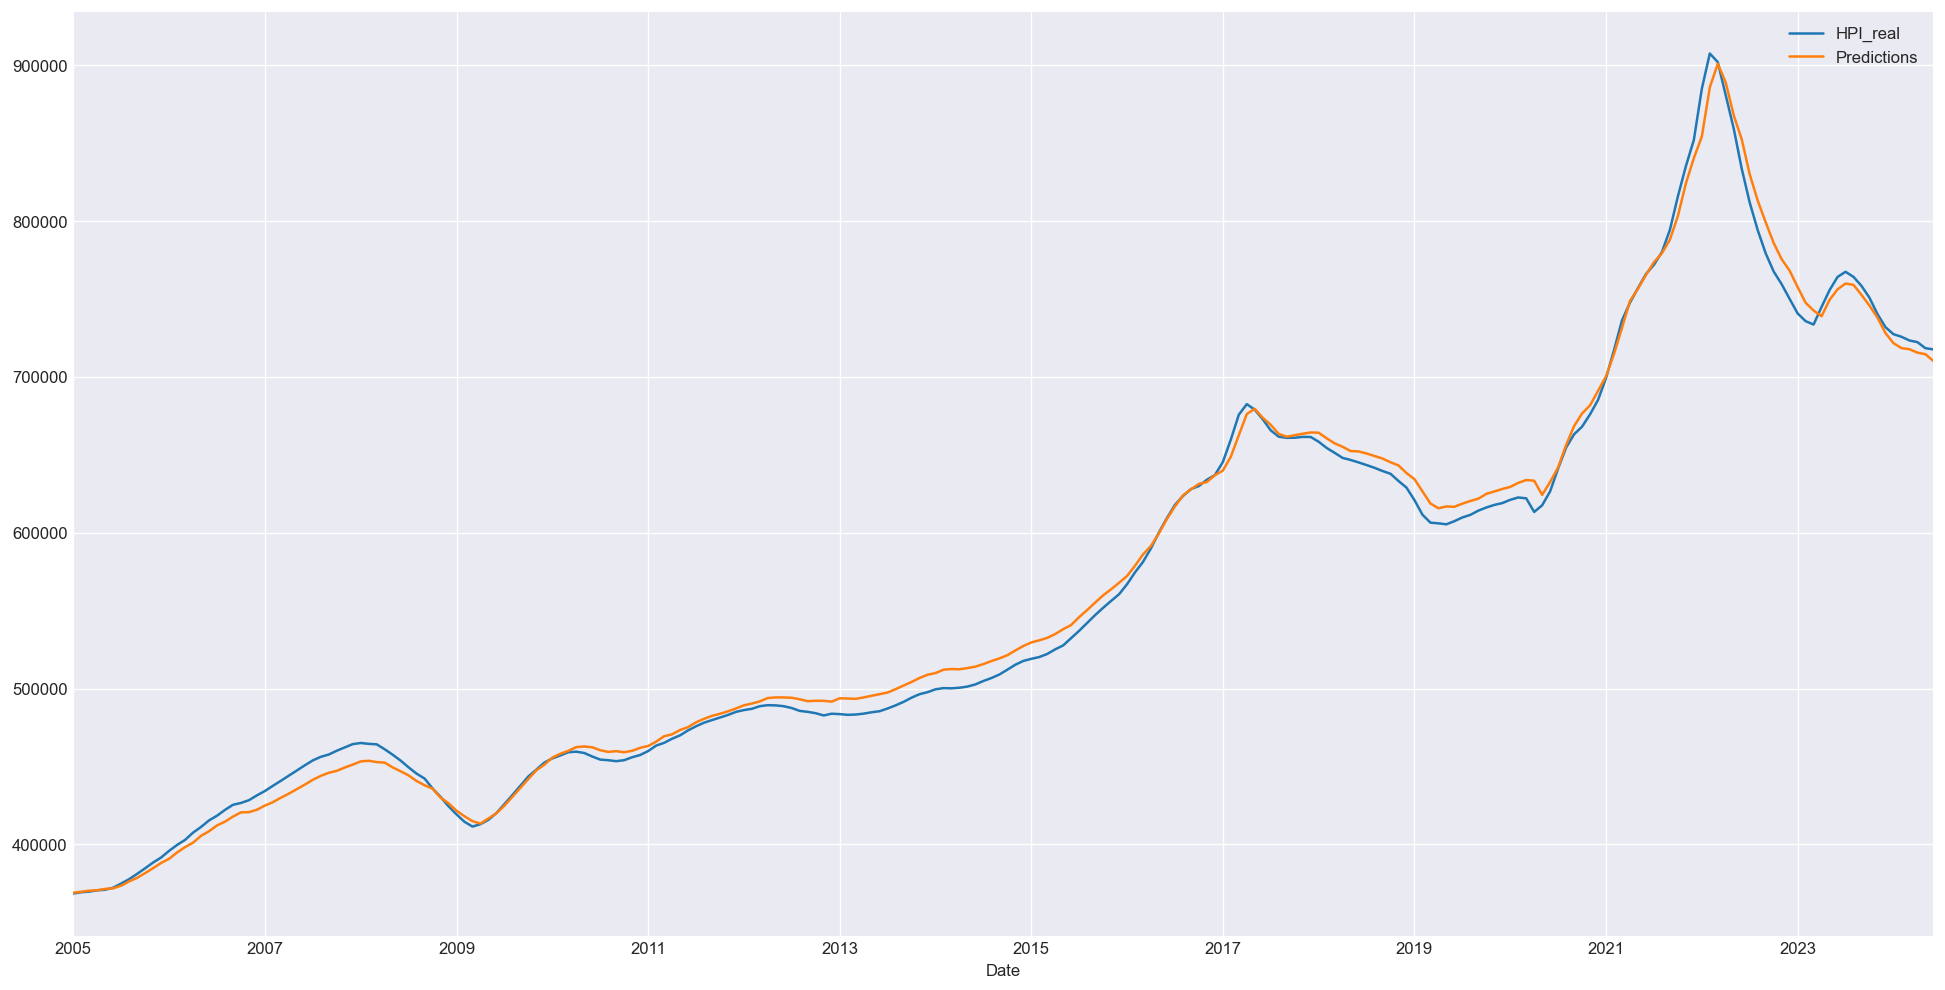

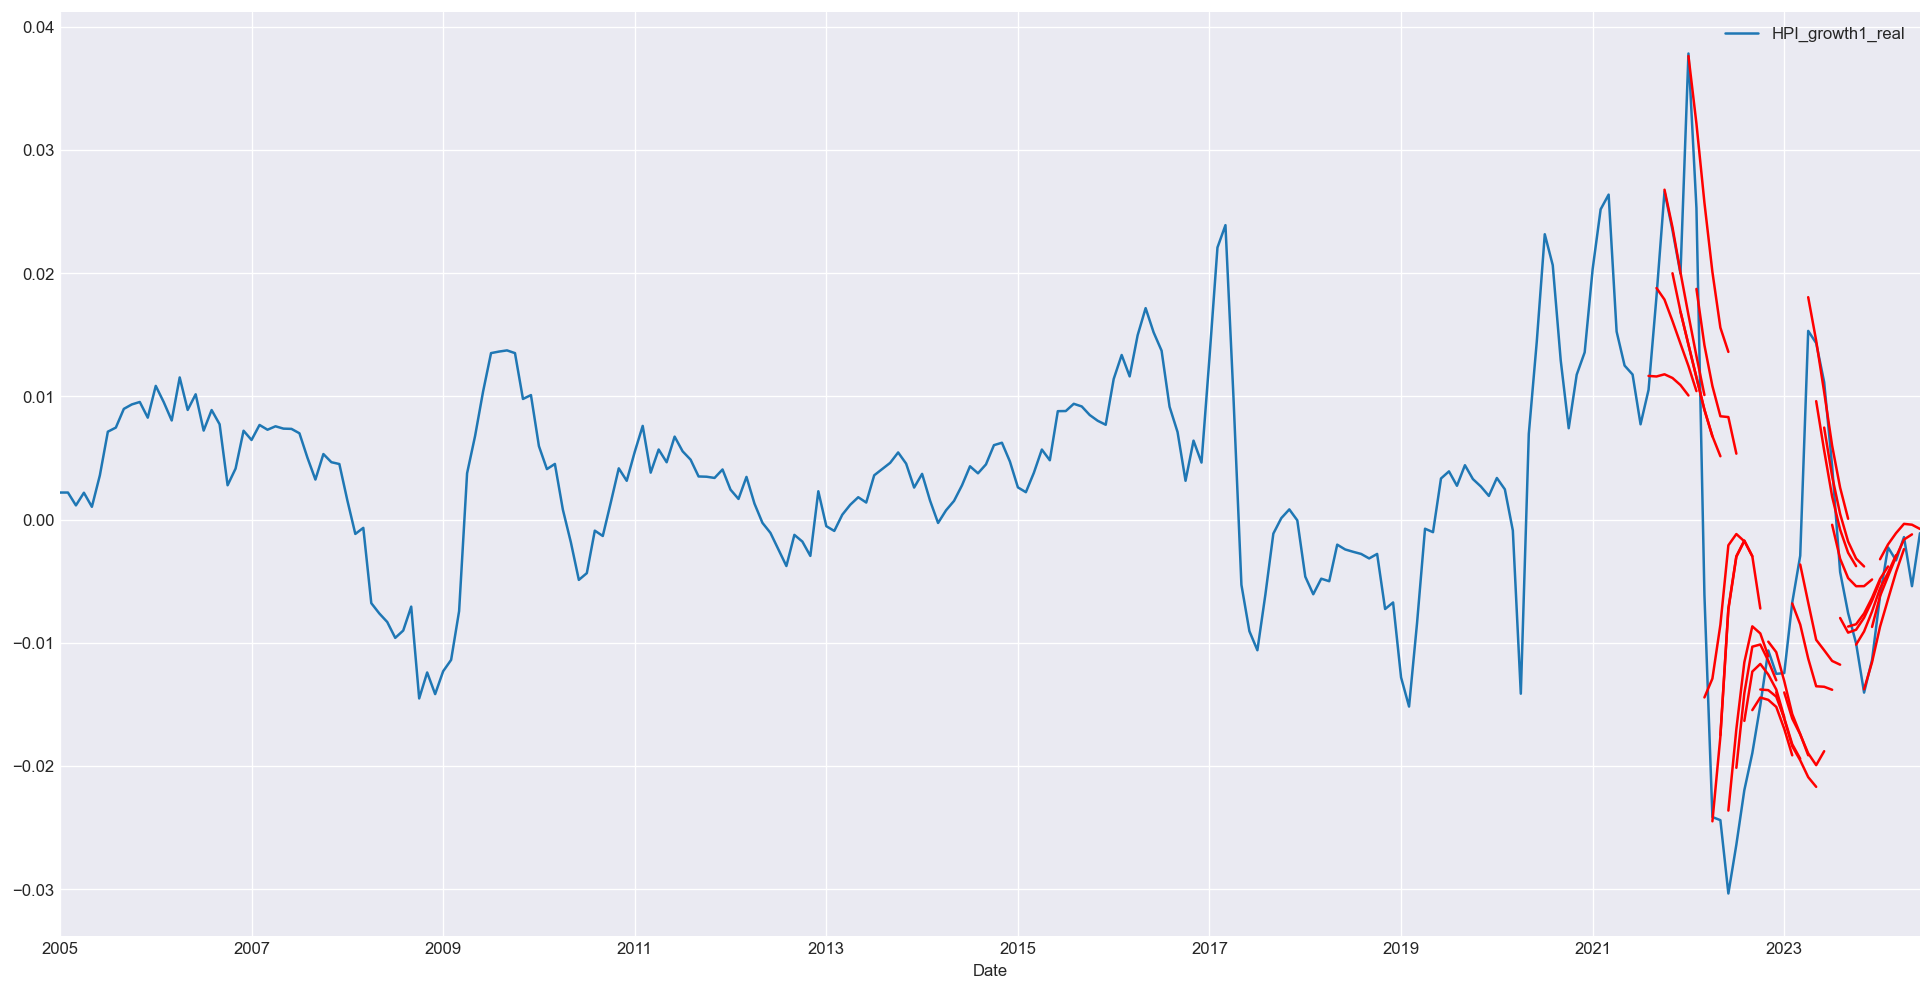

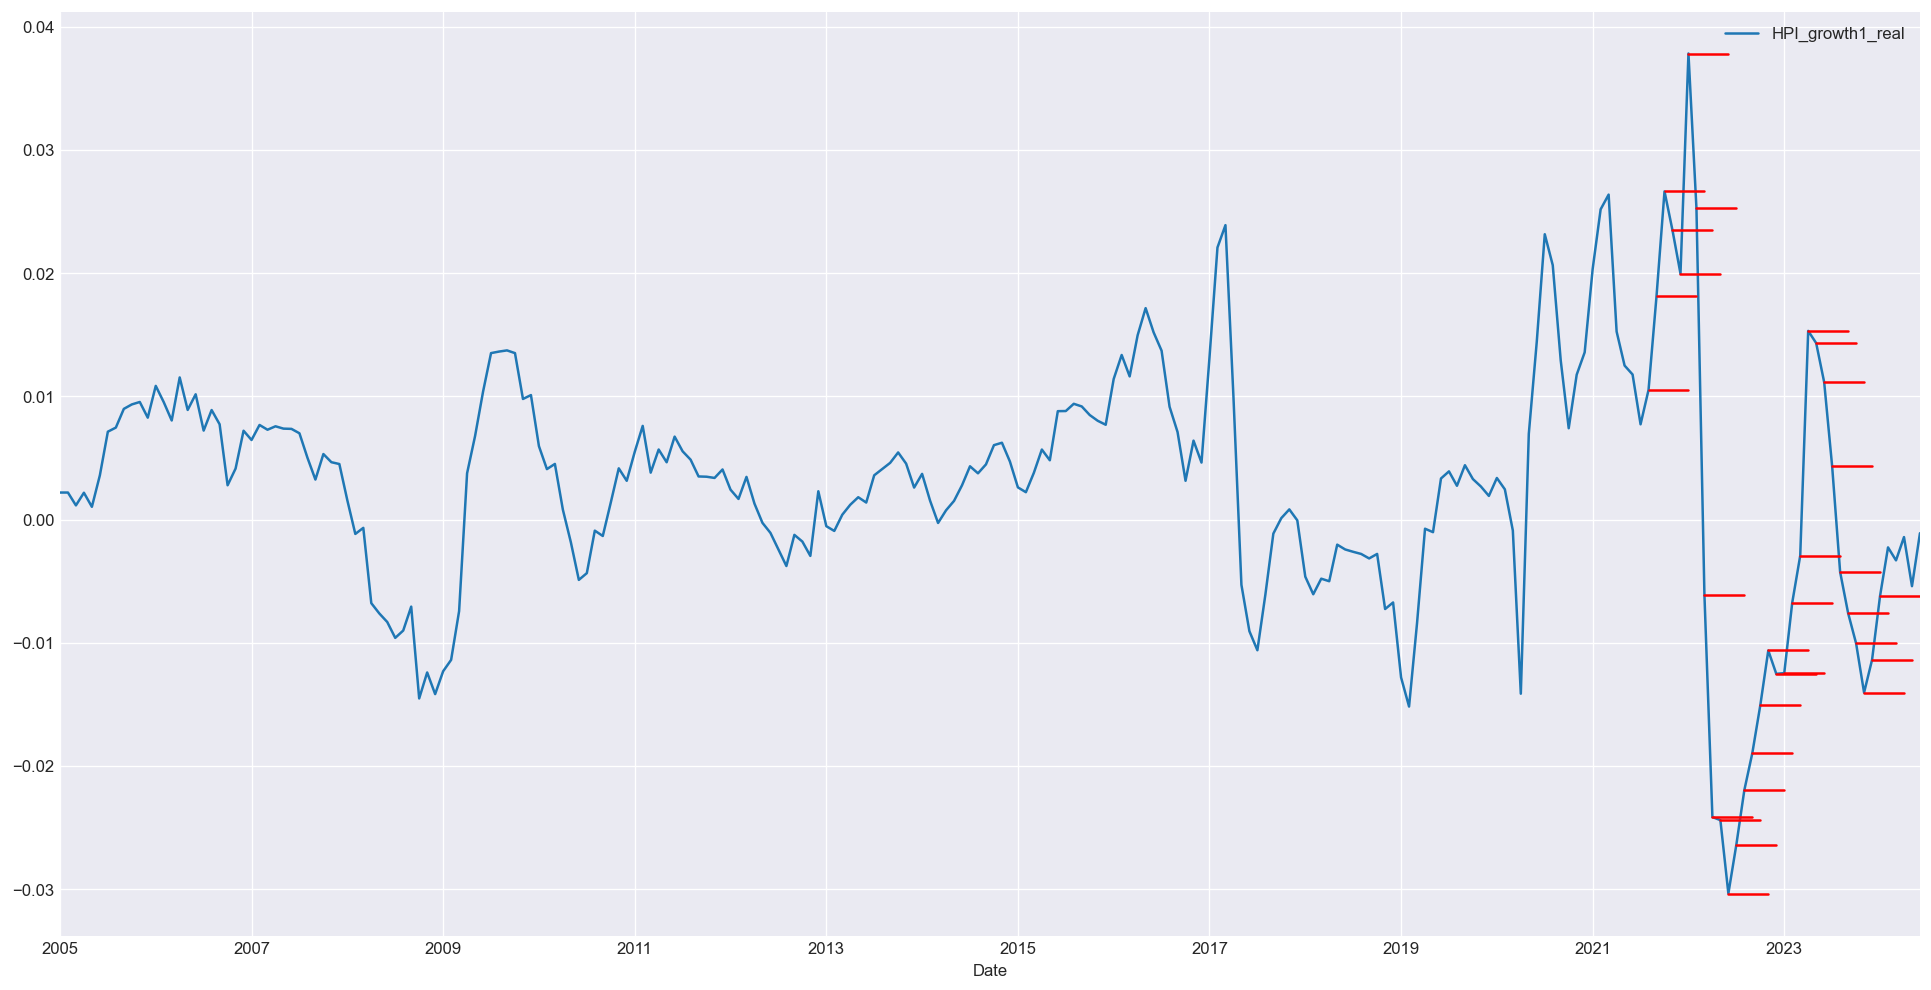

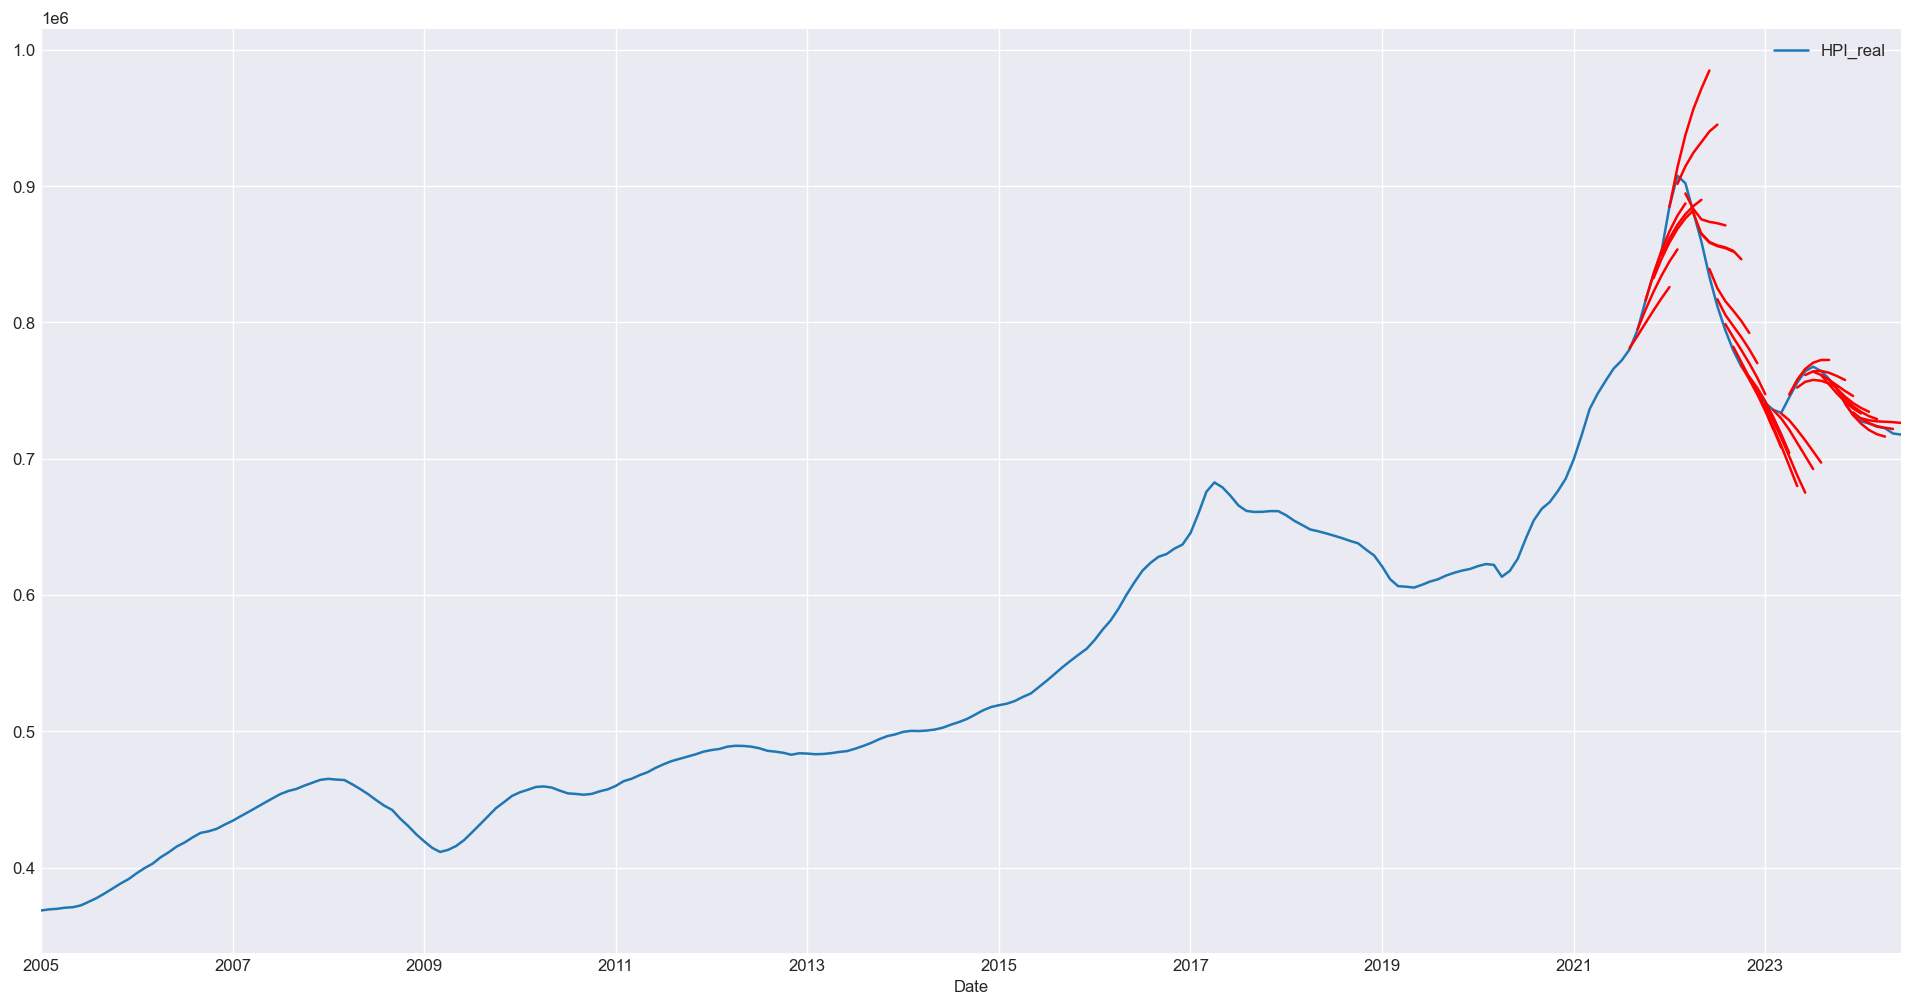

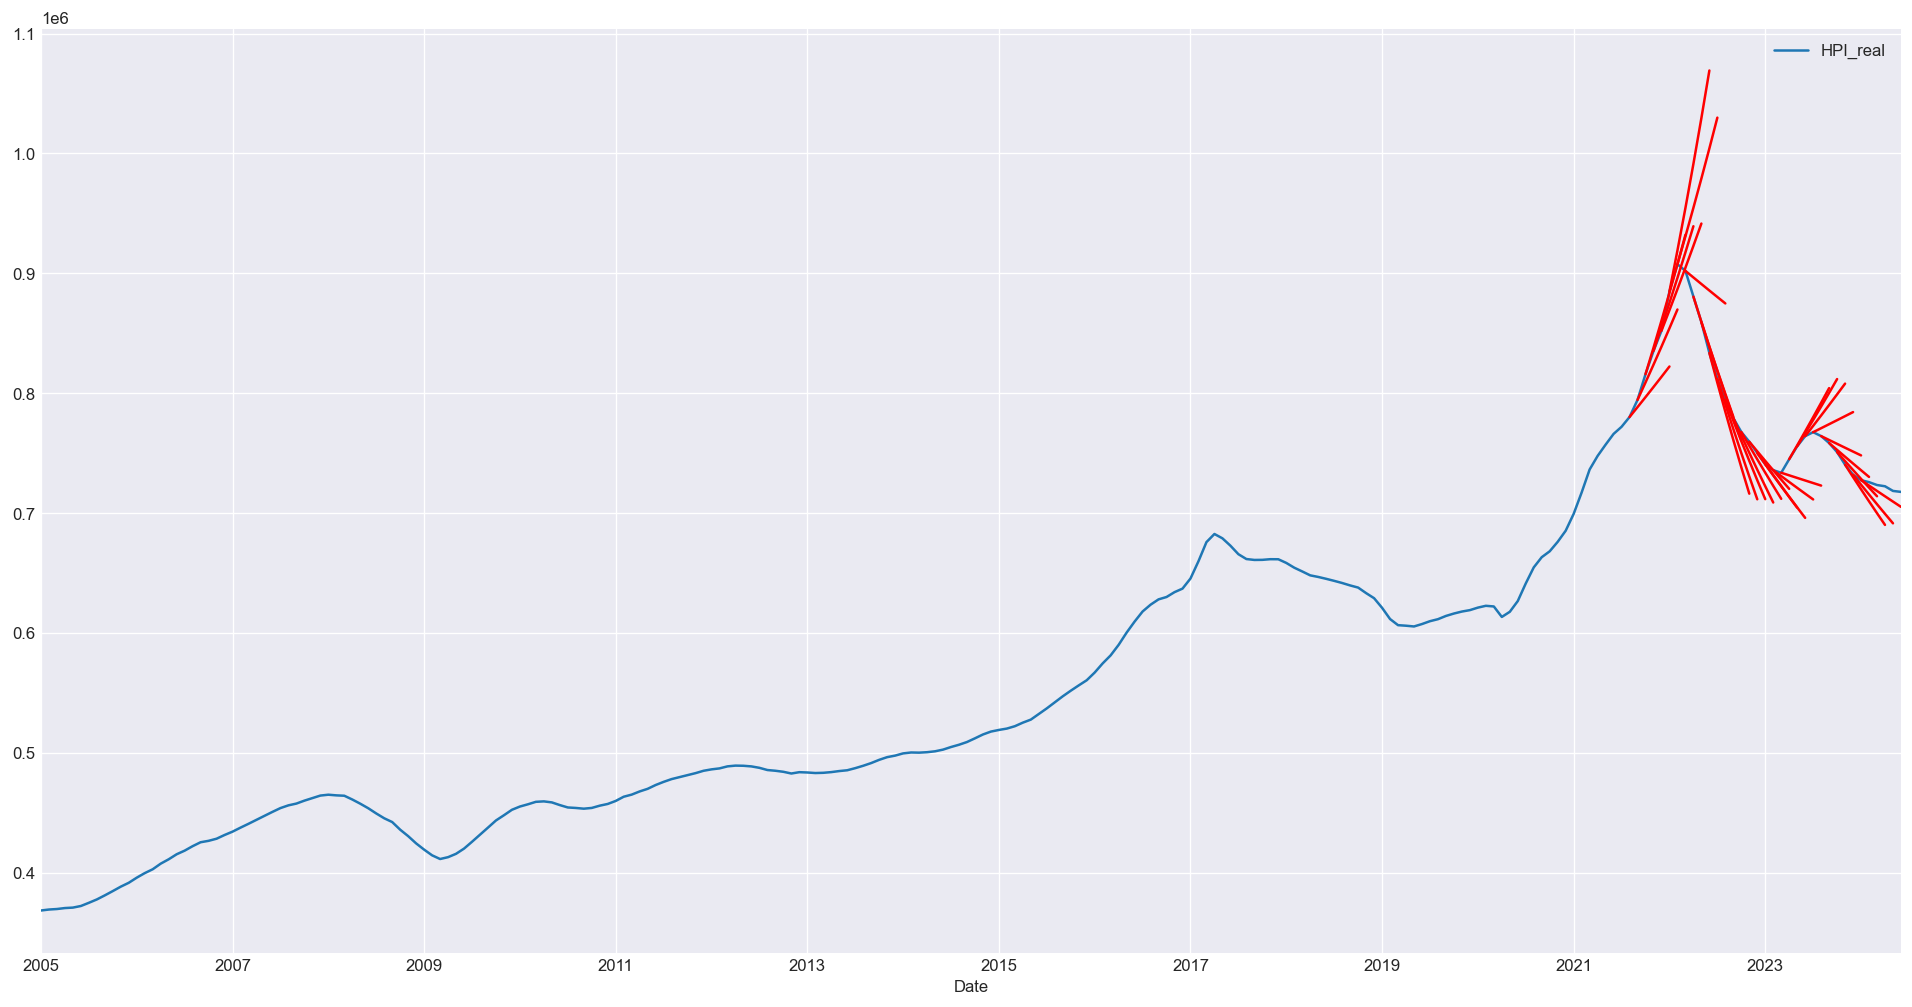

In [7]:
# features = ["M2_growth4_real_lag_2","Mortgage rate 5y_diff1_lag_2","Household saving rate_lag_3"]# 
features = ["Mortgage rate 5y_growth12_lag_6", "M2++_growth1_real_lag_6"]

y_lags = 2
test_split_time = pd.Timestamp("20210725")

features = [target + "_lag_" + str(j) for j in range(y_lags, 0,-1)]  + features

X, y = df_cov[features], df_cov[target]
X_train, y_train = X[:test_split_time], y[:test_split_time]

LR = LinearRegression()
# LR = Lasso(0.000005)
LR.fit(X_train, y_train)
print("coefficients: ", LR.intercept_,  LR.coef_)
preds = LR.predict(X)

forecast = backtesting(df_cov, target, features, test_split_time, 6, y_lags, LR, 1, retrain = True)
forecast2 = backtesting(df_cov, target, features, test_split_time, 6, 1, MA, 1, retrain = True)

series_args = [[forecast, "Backtesting"],
               [forecast2, "Naive"],
               ]

show_results(y, preds, test_split_time)
show_results(df["HPI_real"], preds, test_split_time, inverse_transform = True)

show_backteting(series_args, y)
show_backteting(series_args, df["HPI_real"], inverse_transform=True)

sm_est = sm.OLS(y_train, sm.add_constant(X_train))
sm_est2 = sm_est.fit()
print(sm_est2.summary())

## Residual Analysis

(-14.15344001860625, 2.1419634473895494e-26, 0, 233, {'1%': -3.458731141928624, '5%': -2.8740258764297293, '10%': -2.5734243167124093}, -1738.109086843084)


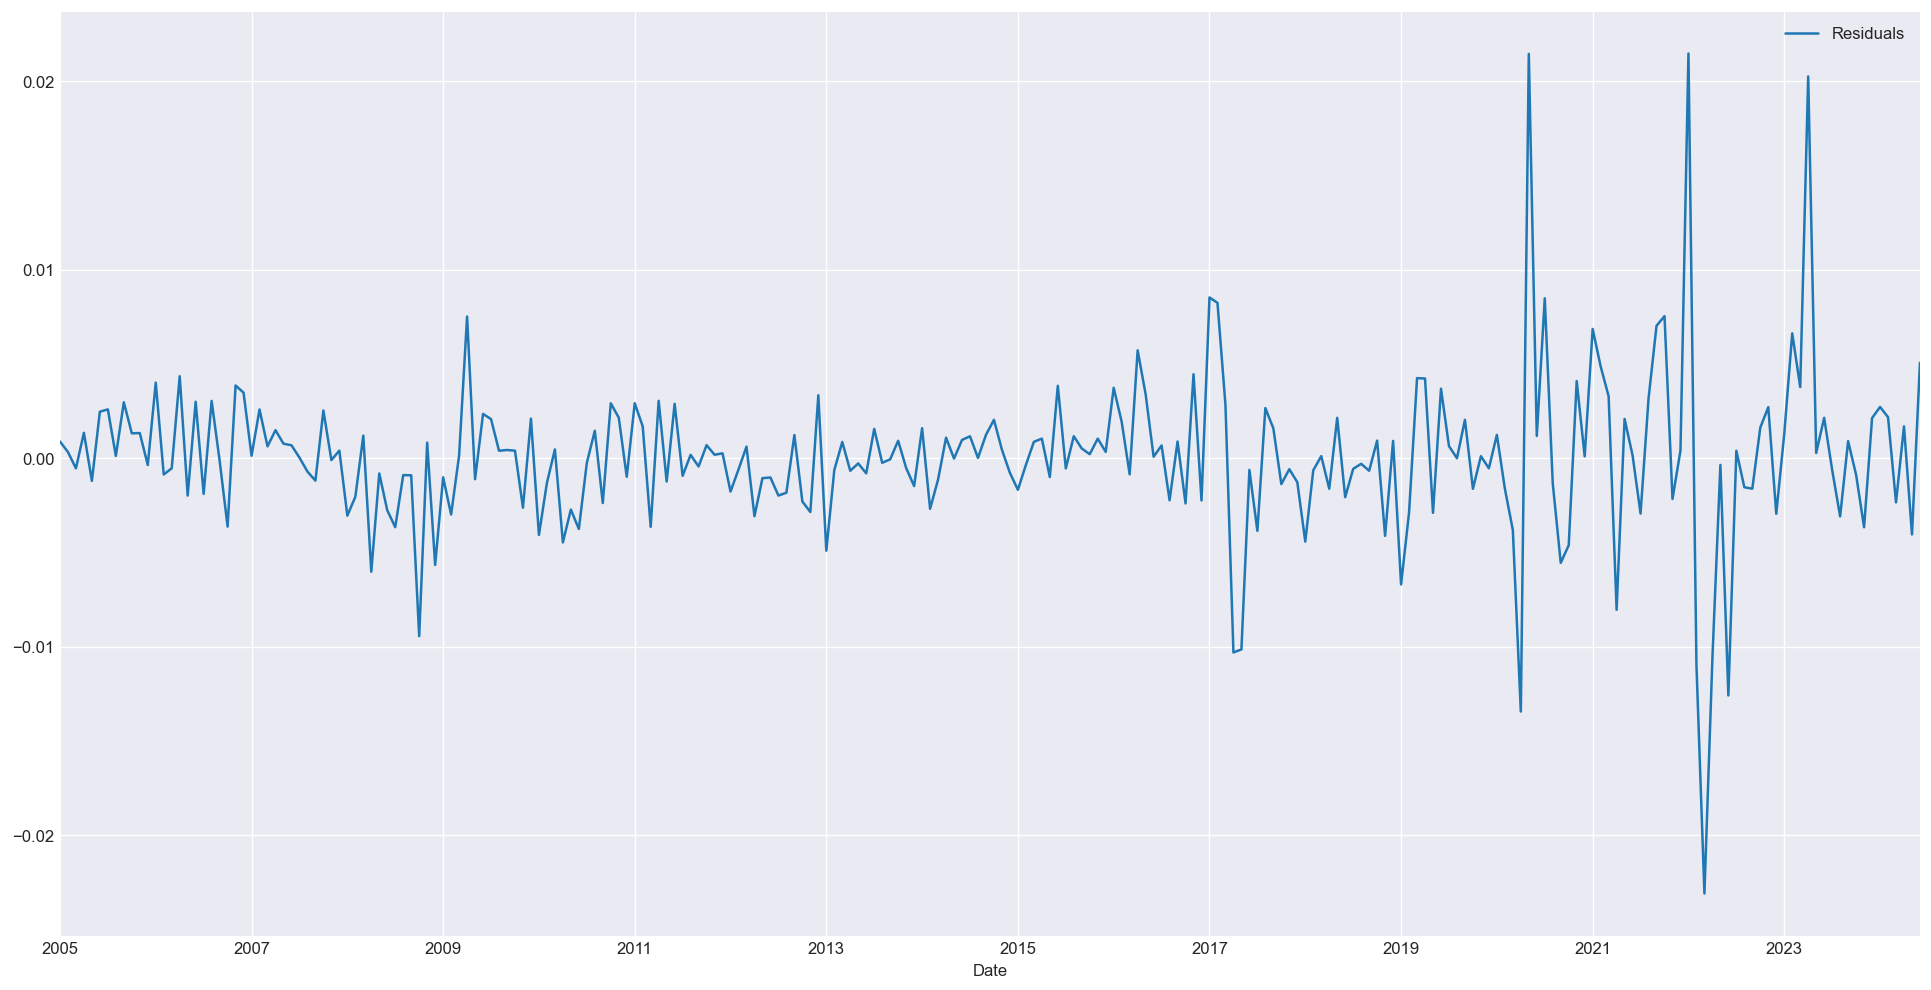

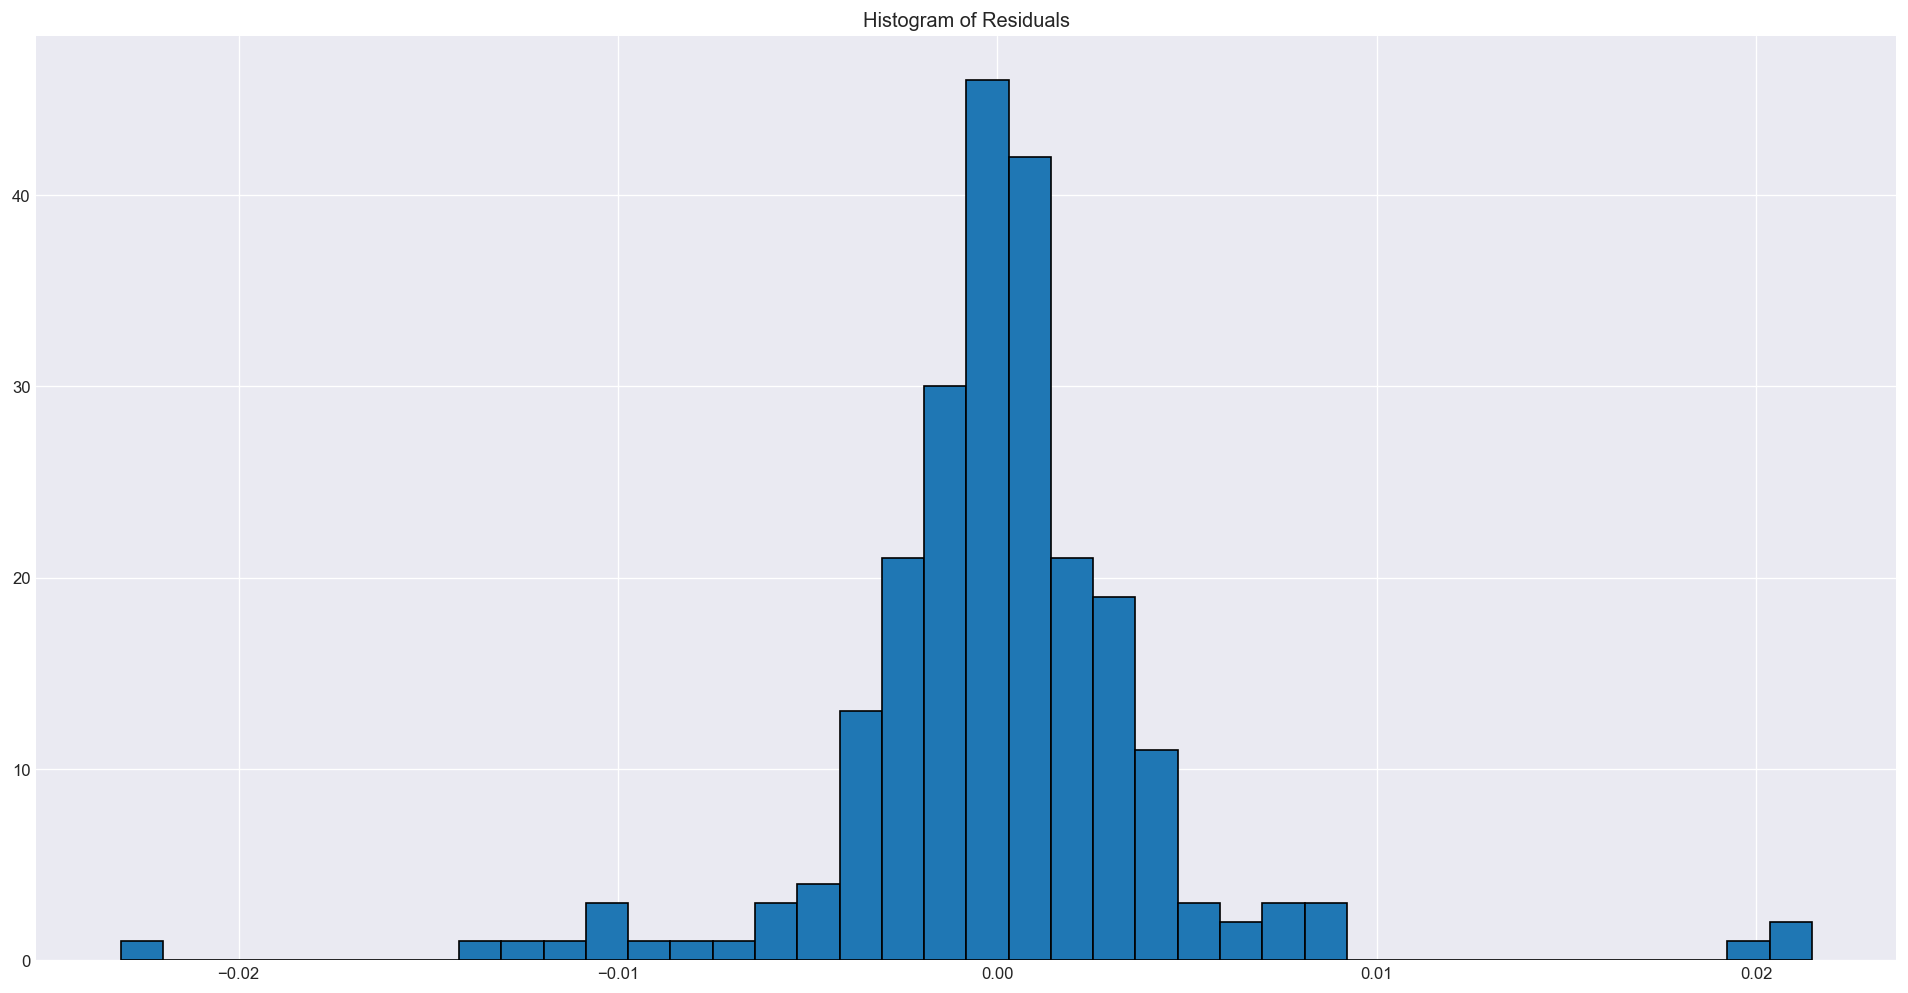

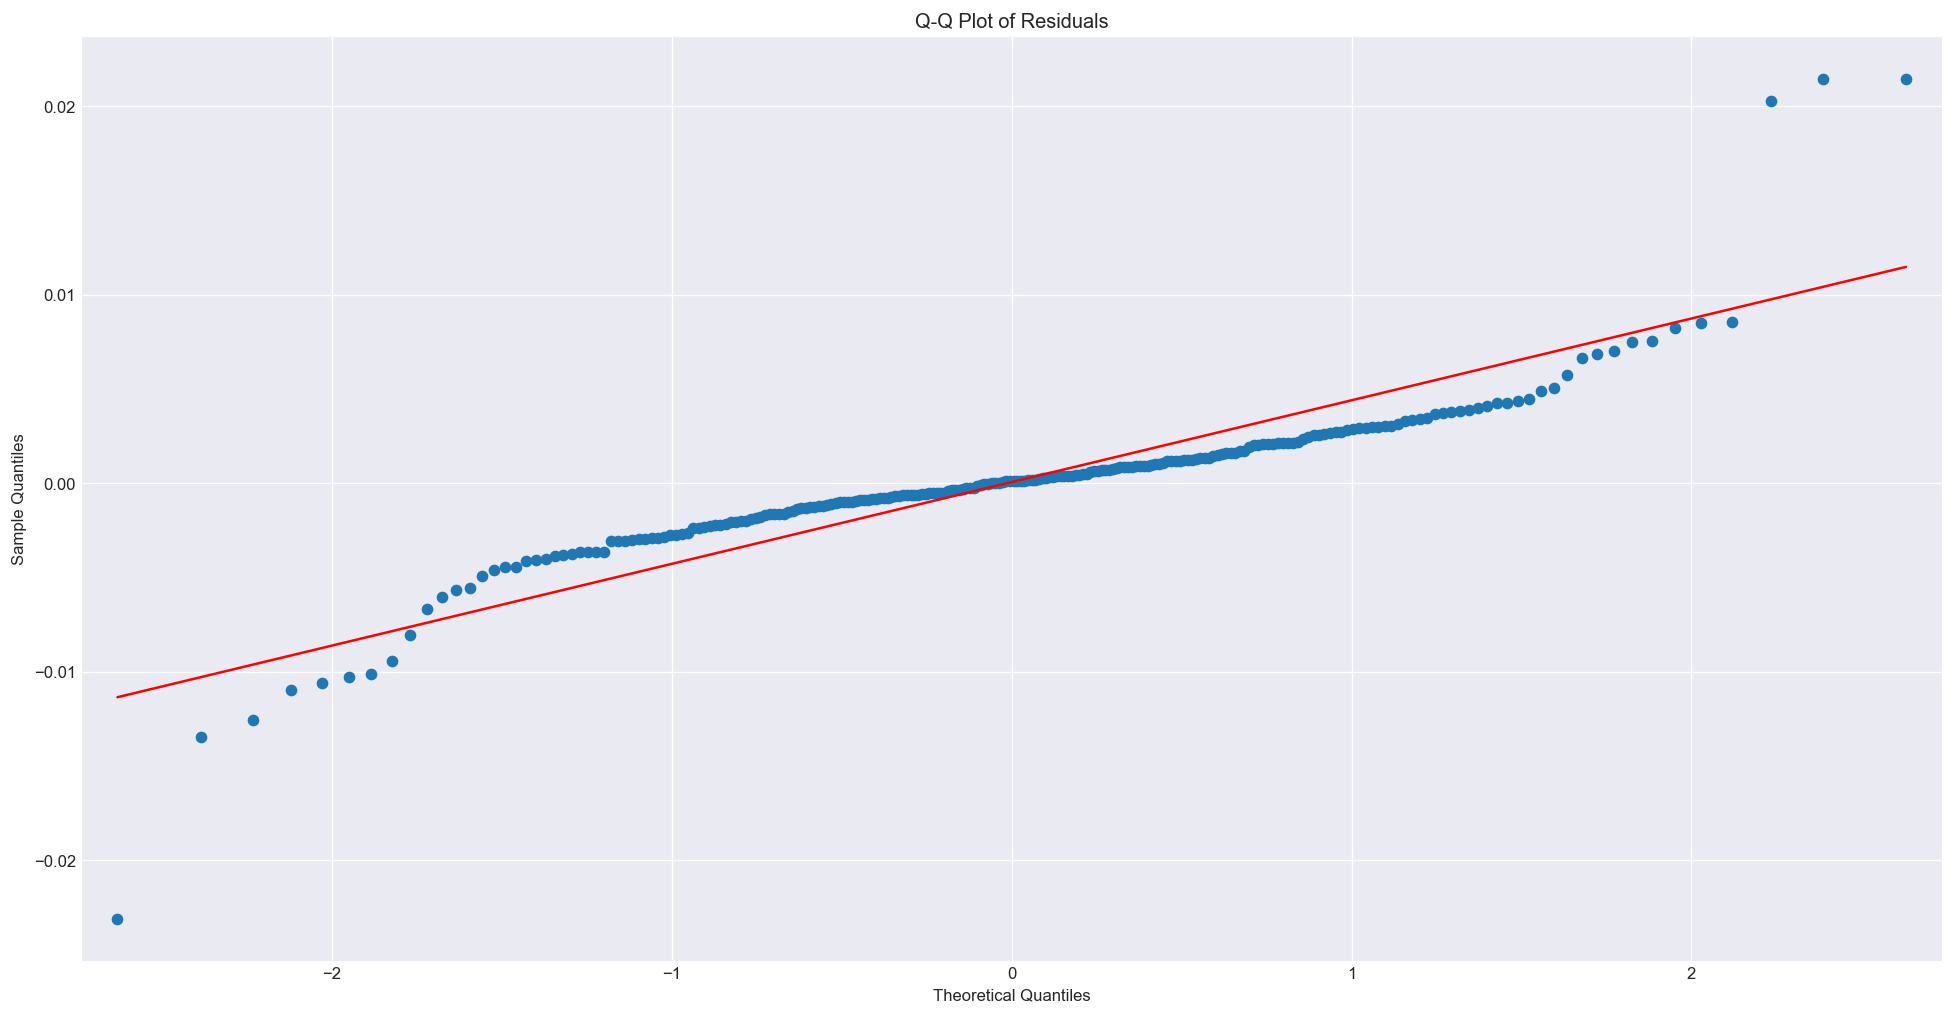

In [8]:
residuals = (df_cov[target].values- preds)
pd.DataFrame(residuals, columns=["Residuals"], index = df_cov.index).plot()

print(adfuller(residuals))
plt.figure()
plt.hist(residuals, bins=40, edgecolor='k')
plt.title('Histogram of Residuals')
plt.show()

sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

## Forecast

In [9]:
def show_forecast(series, pred, inverse_transform=True):
    """
    Display the actual series and forecasted values on a plot.

    Parameters:
    - series (pd.Series): The actual time series data.
    - pred (pd.Series): The forecasted values.
    - inverse_transform (bool): Whether to apply inverse transformations to predictions.

    Returns:
    - None
    """
    if inverse_transform:
        pred = inv_growth(pred, series.iloc[-1])

    plt.figure()
    pred.plot(legend="top", label="Forecast")
    series.plot(legend="top", label="Actual")

    print(pred)


2024-07-01    716863.900807
2024-08-01    716037.326303
2024-09-01    715297.818543
2024-10-01    714666.821631
2024-11-01    714208.188511
2024-12-01    713901.352565
Freq: MS, Name: Forecast, dtype: float64
2024-07-01   -0.001166
2024-08-01   -0.001154
2024-09-01   -0.001033
2024-10-01   -0.000883
2024-11-01   -0.000642
2024-12-01   -0.000430
Freq: MS, Name: Forecast, dtype: float64


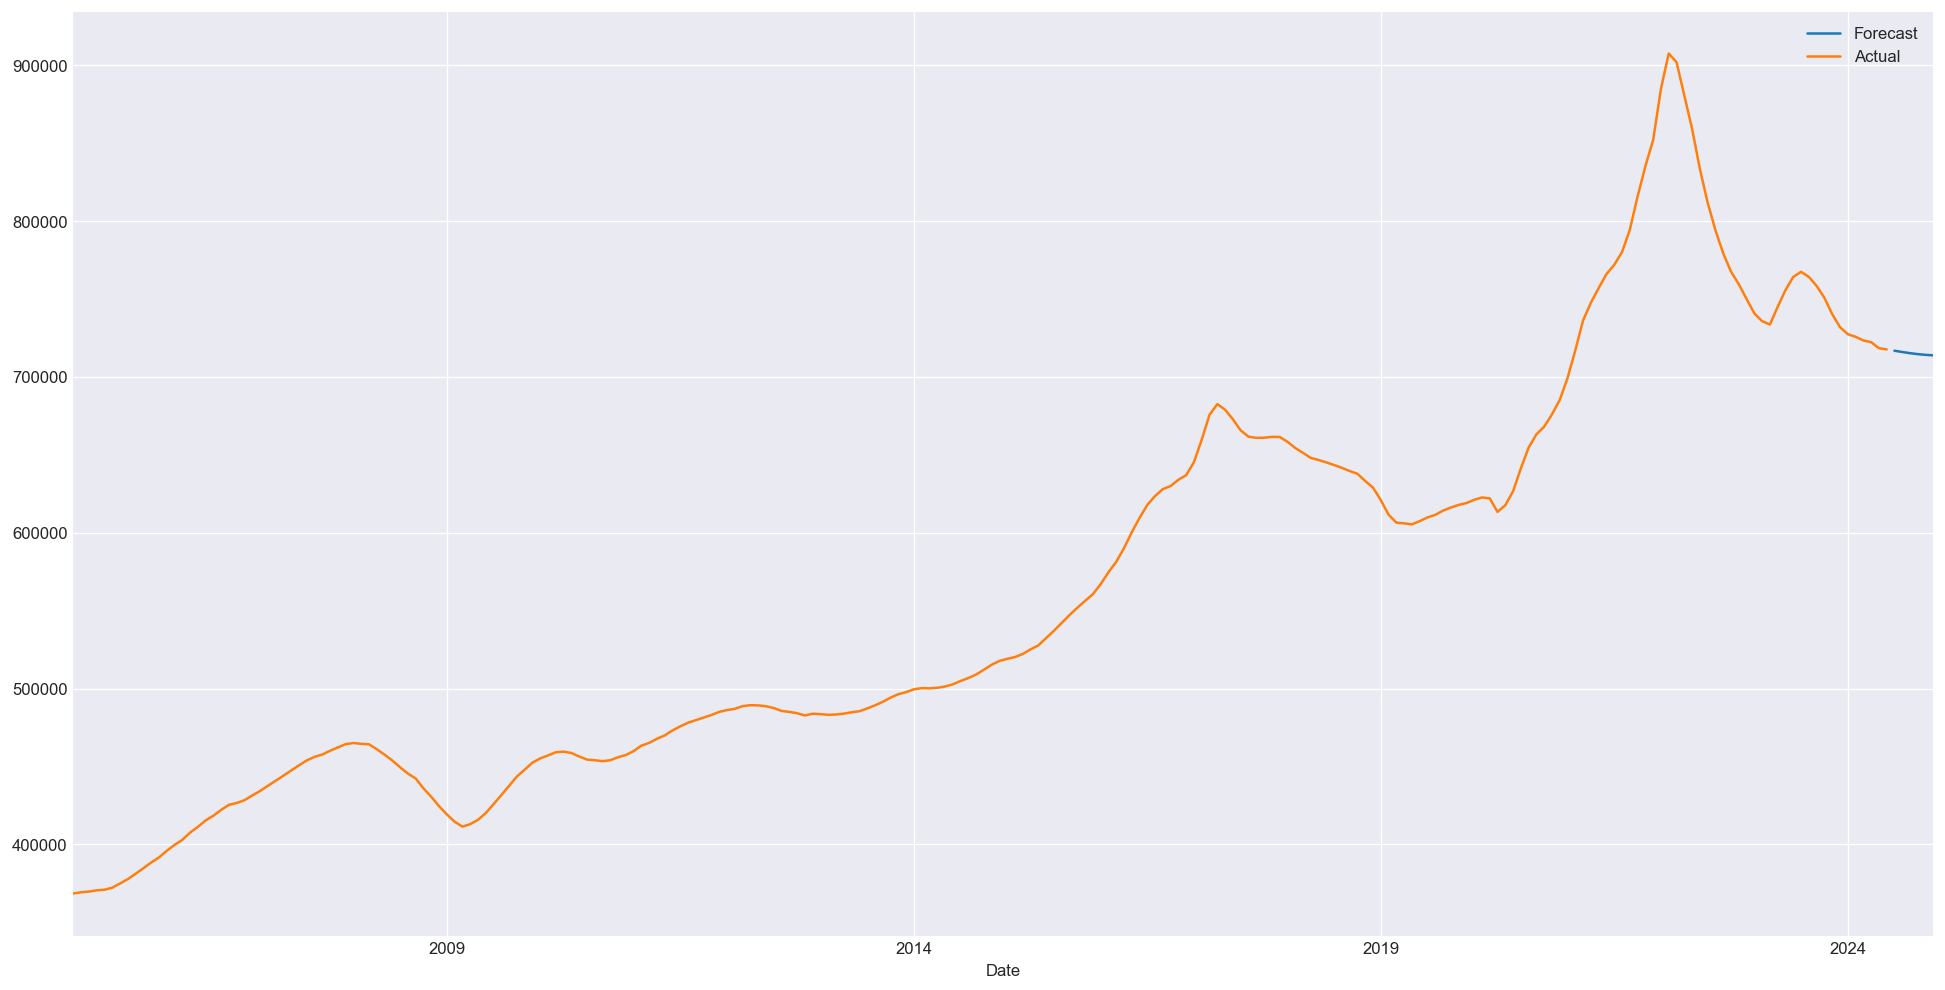

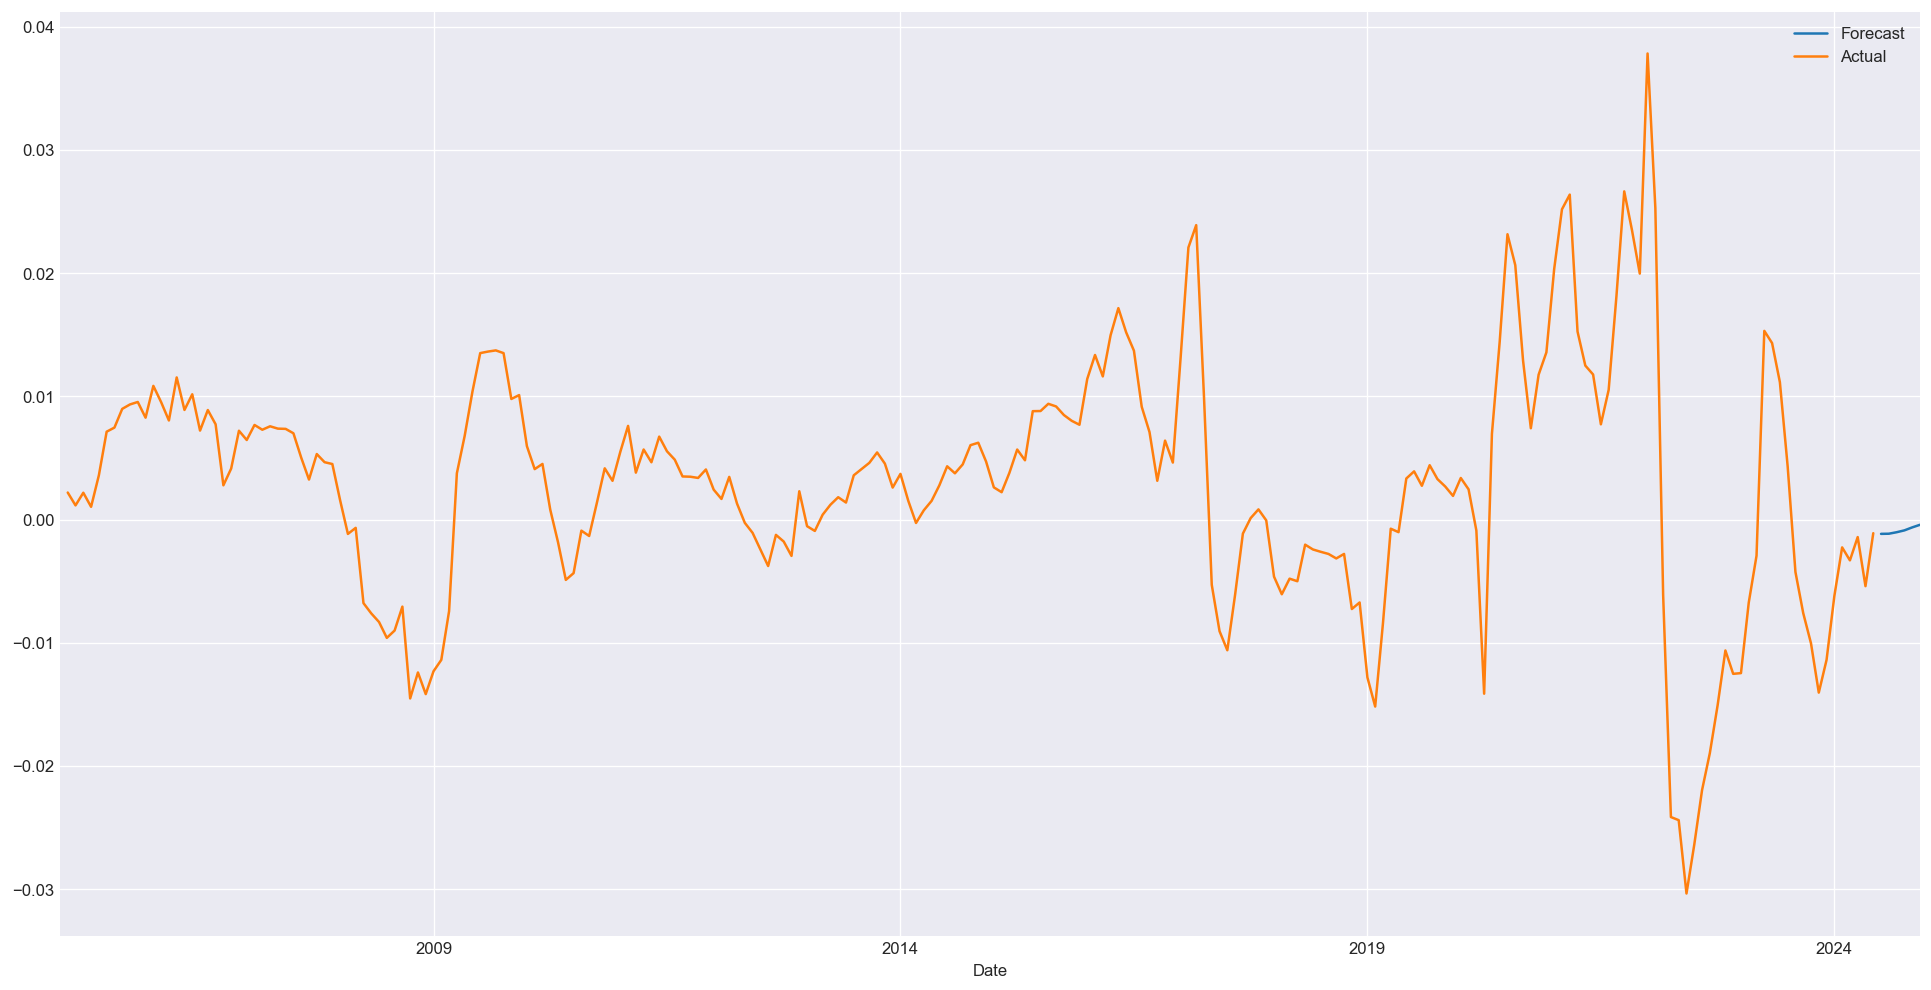

In [10]:
forecast3 = predict(df_cov, target,  ["Mortgage rate 5y_growth12_lag_6", "M2_growth12_real_lag_6"], 6, 1, LR)

show_forecast(df["HPI_real"], forecast3)
show_forecast(df["HPI_growth1_real"], forecast3, False)

# Custom Plots

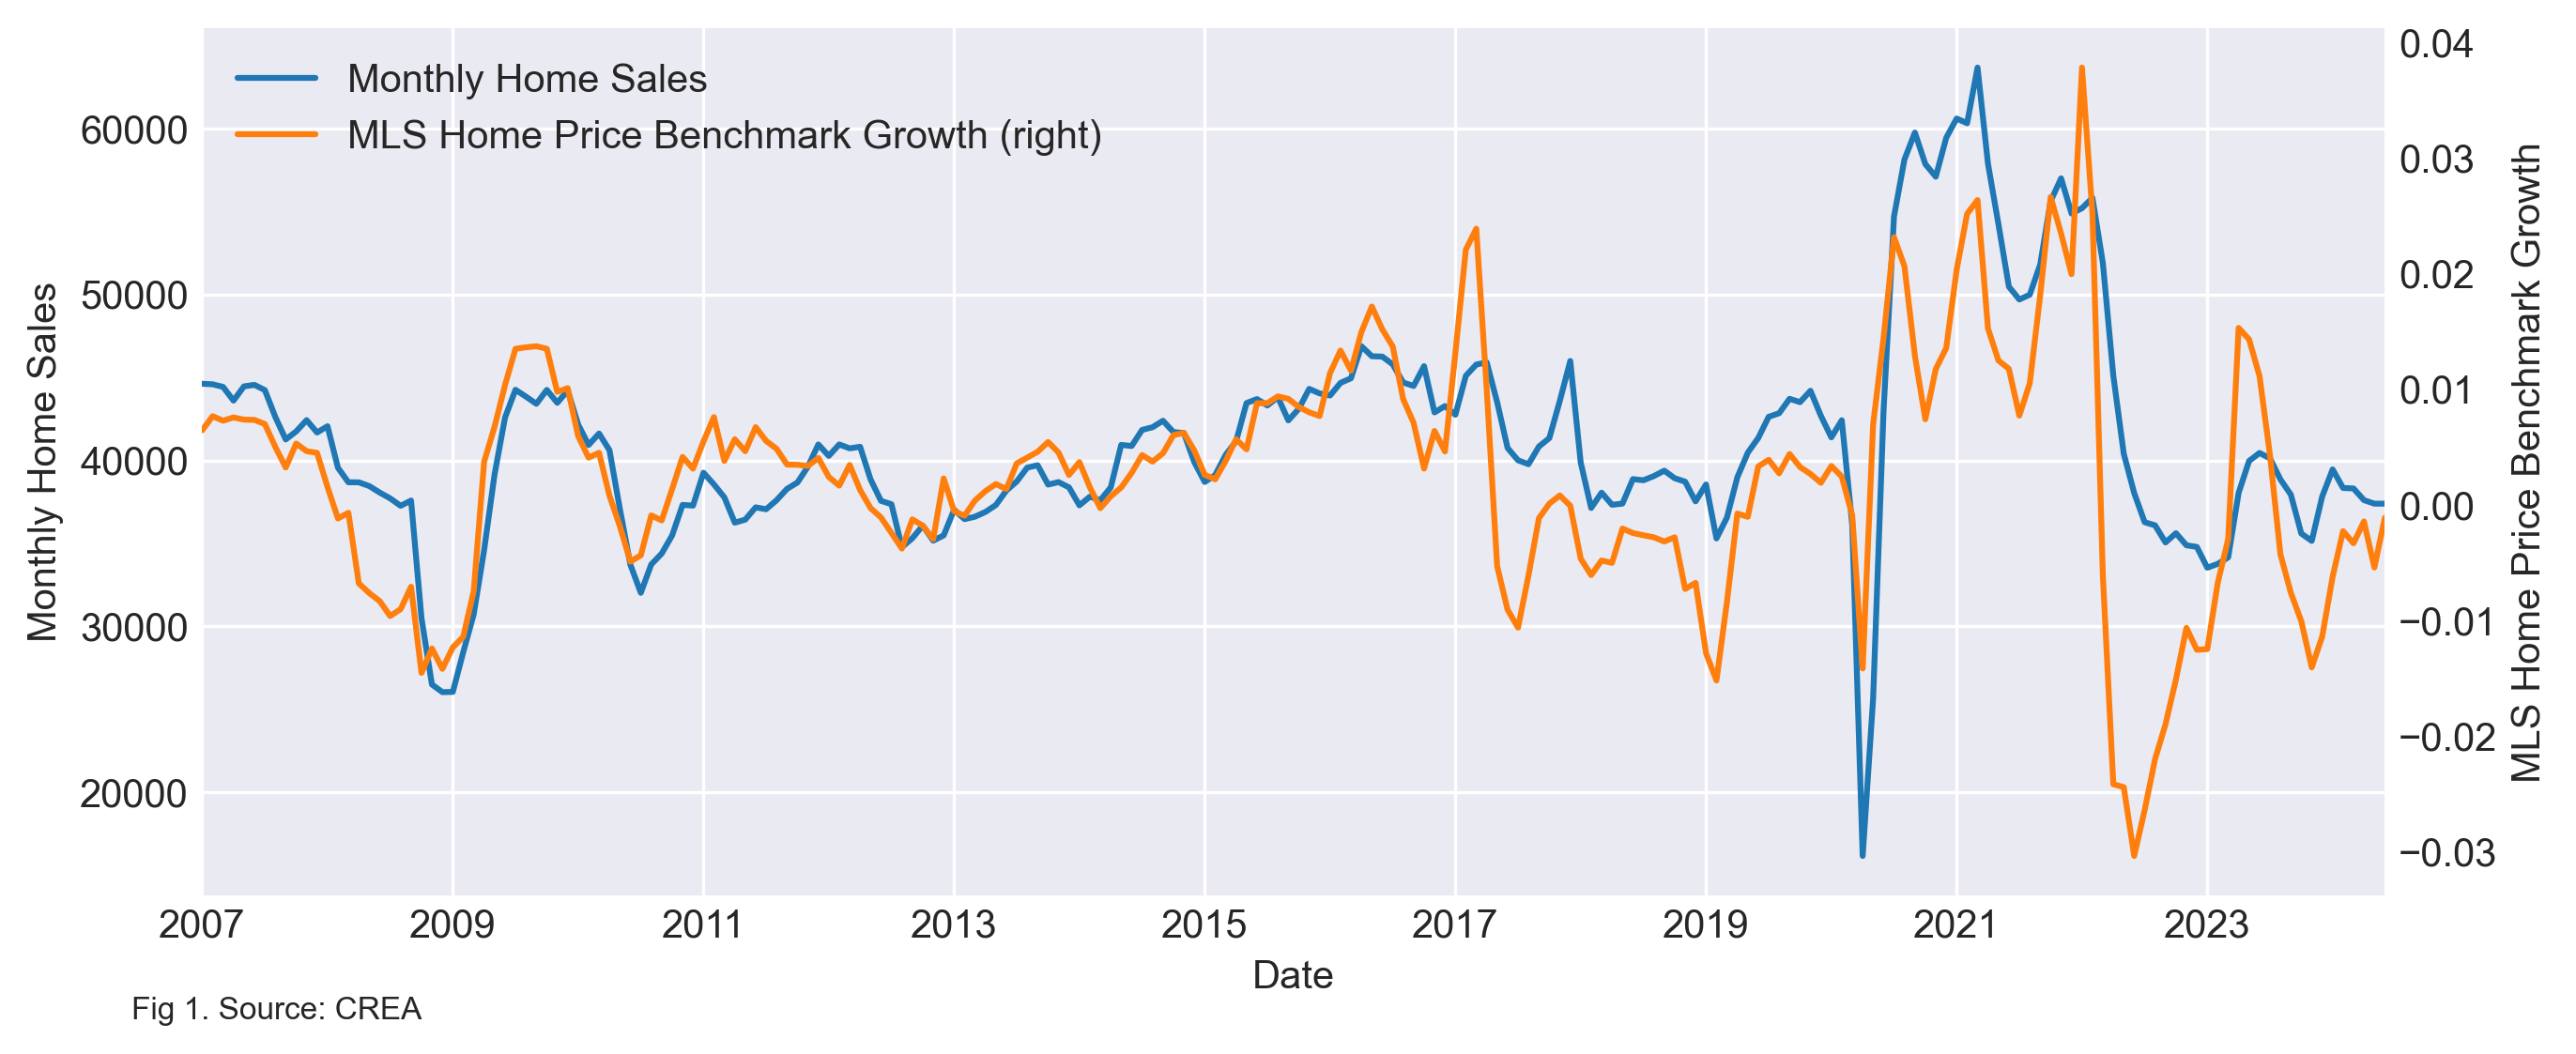

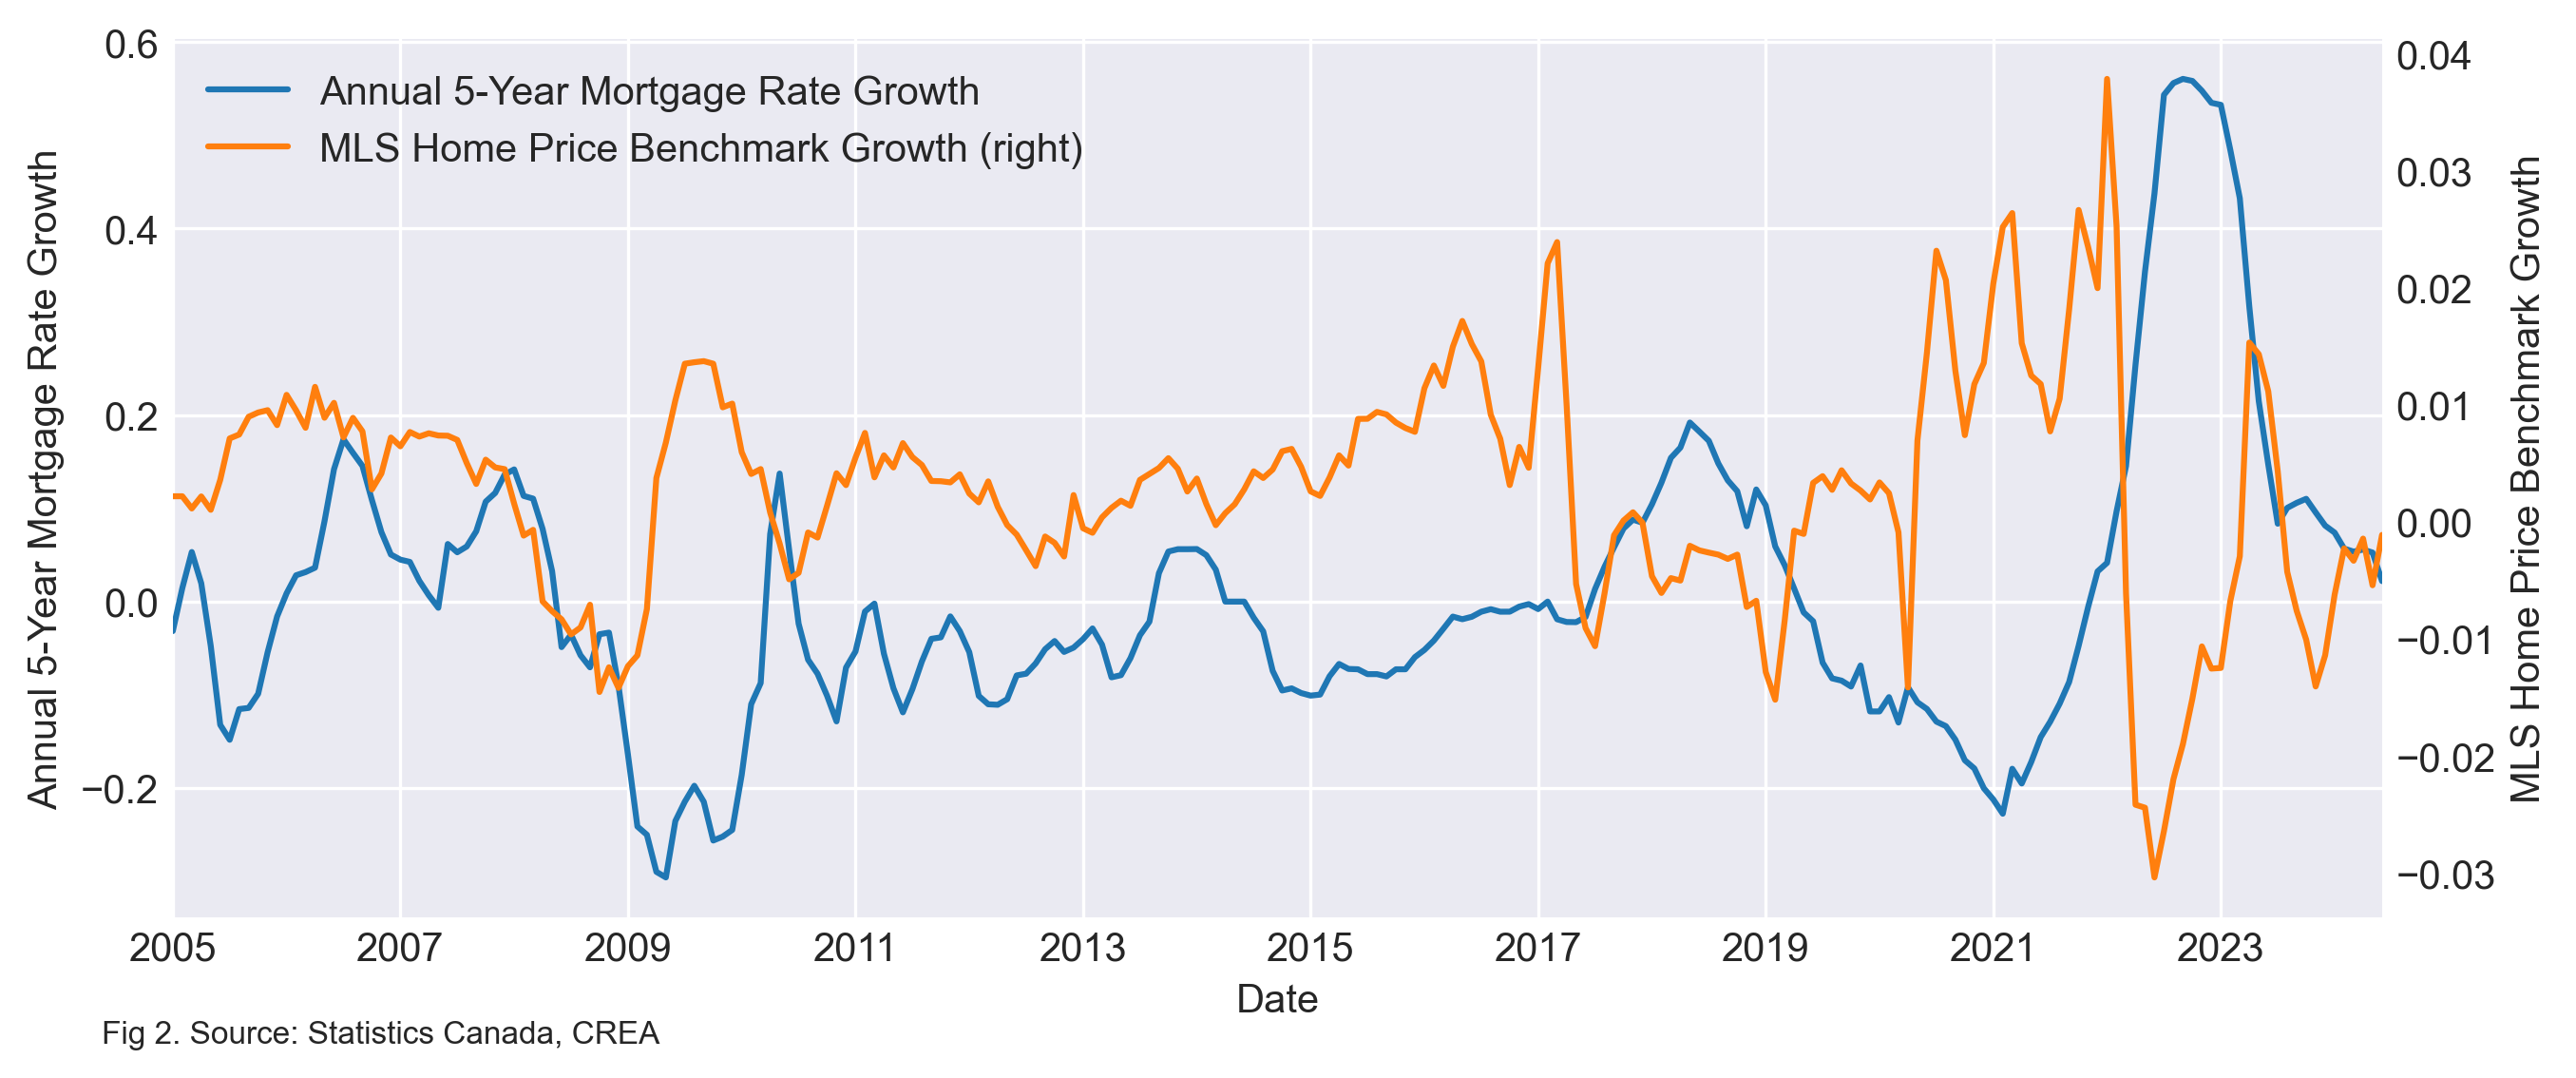

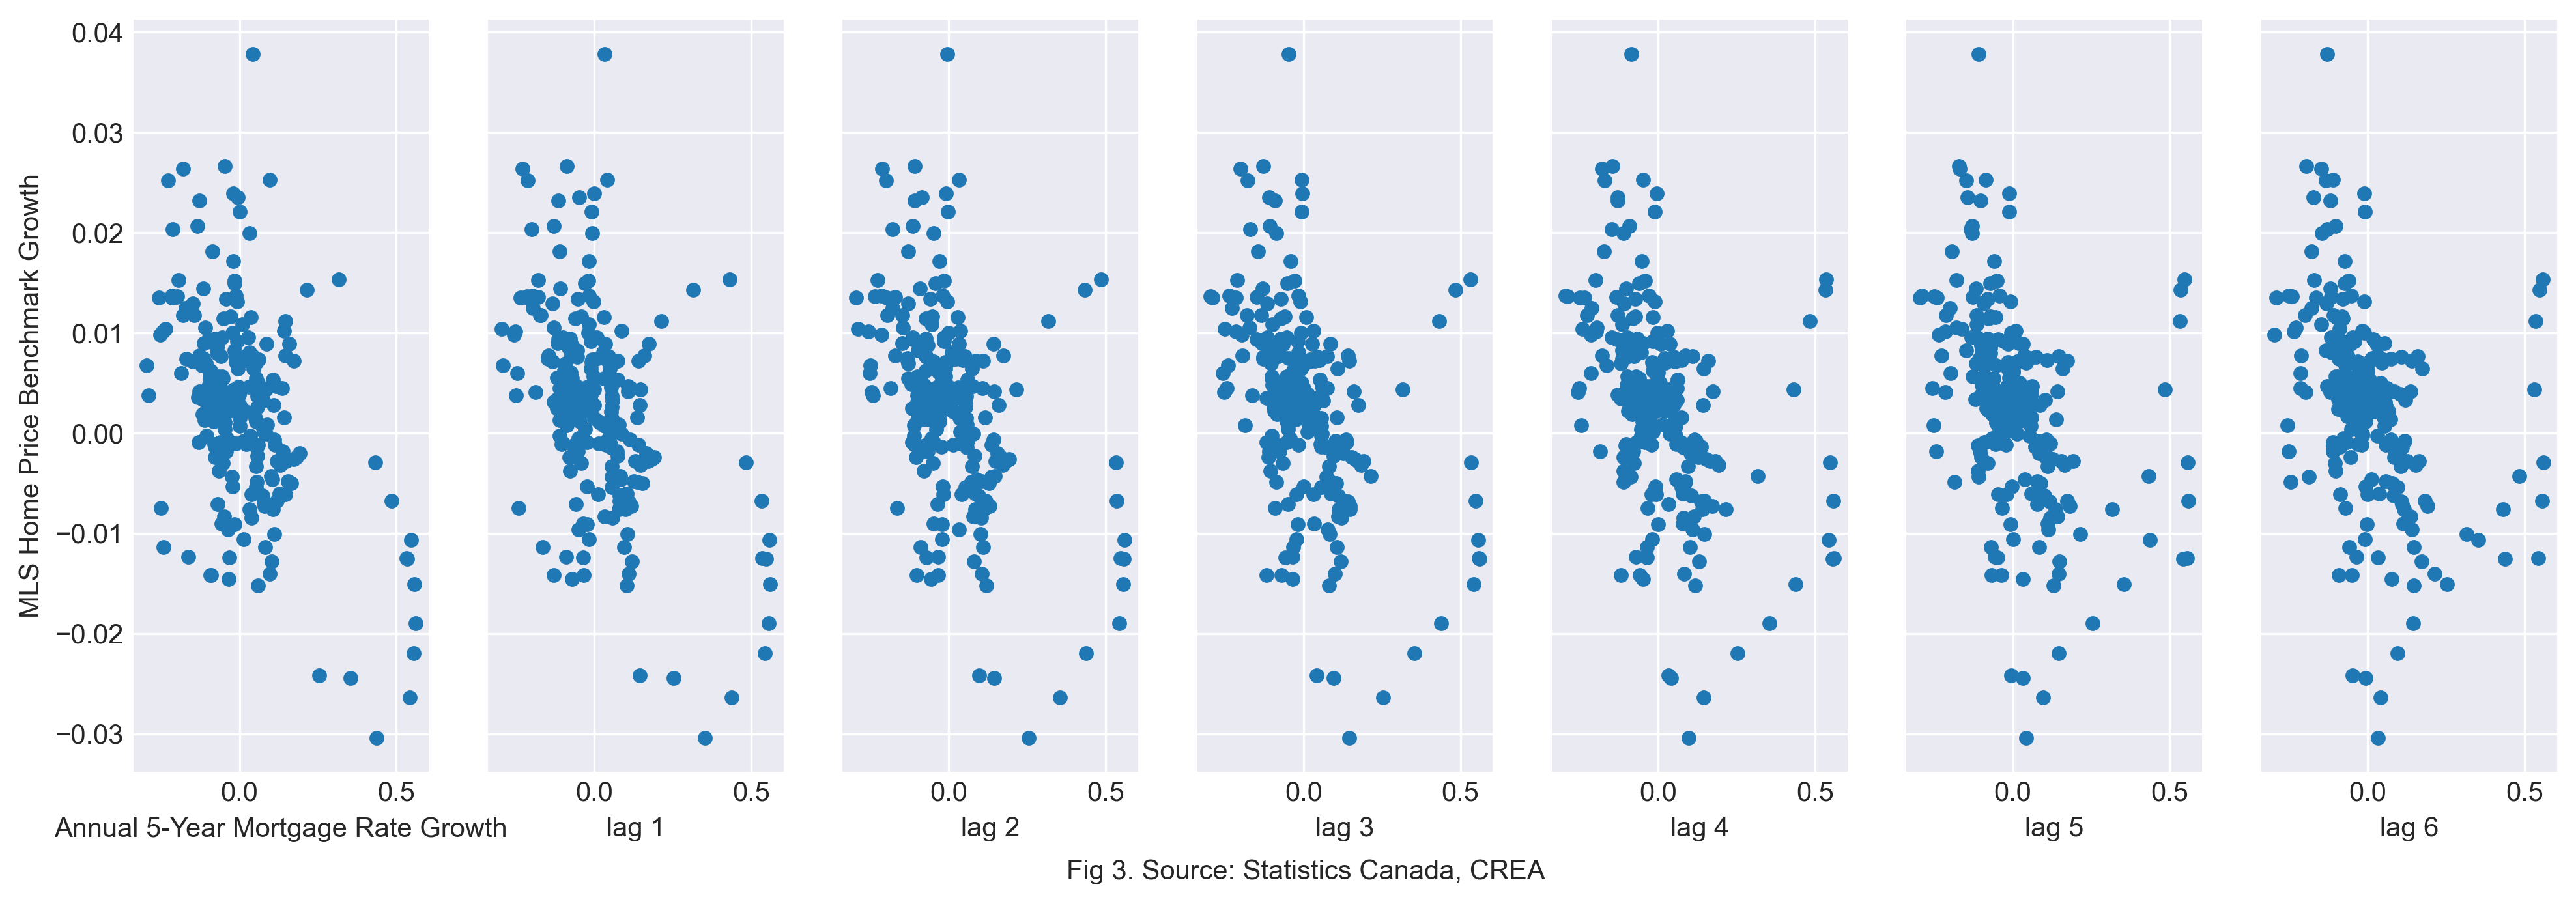

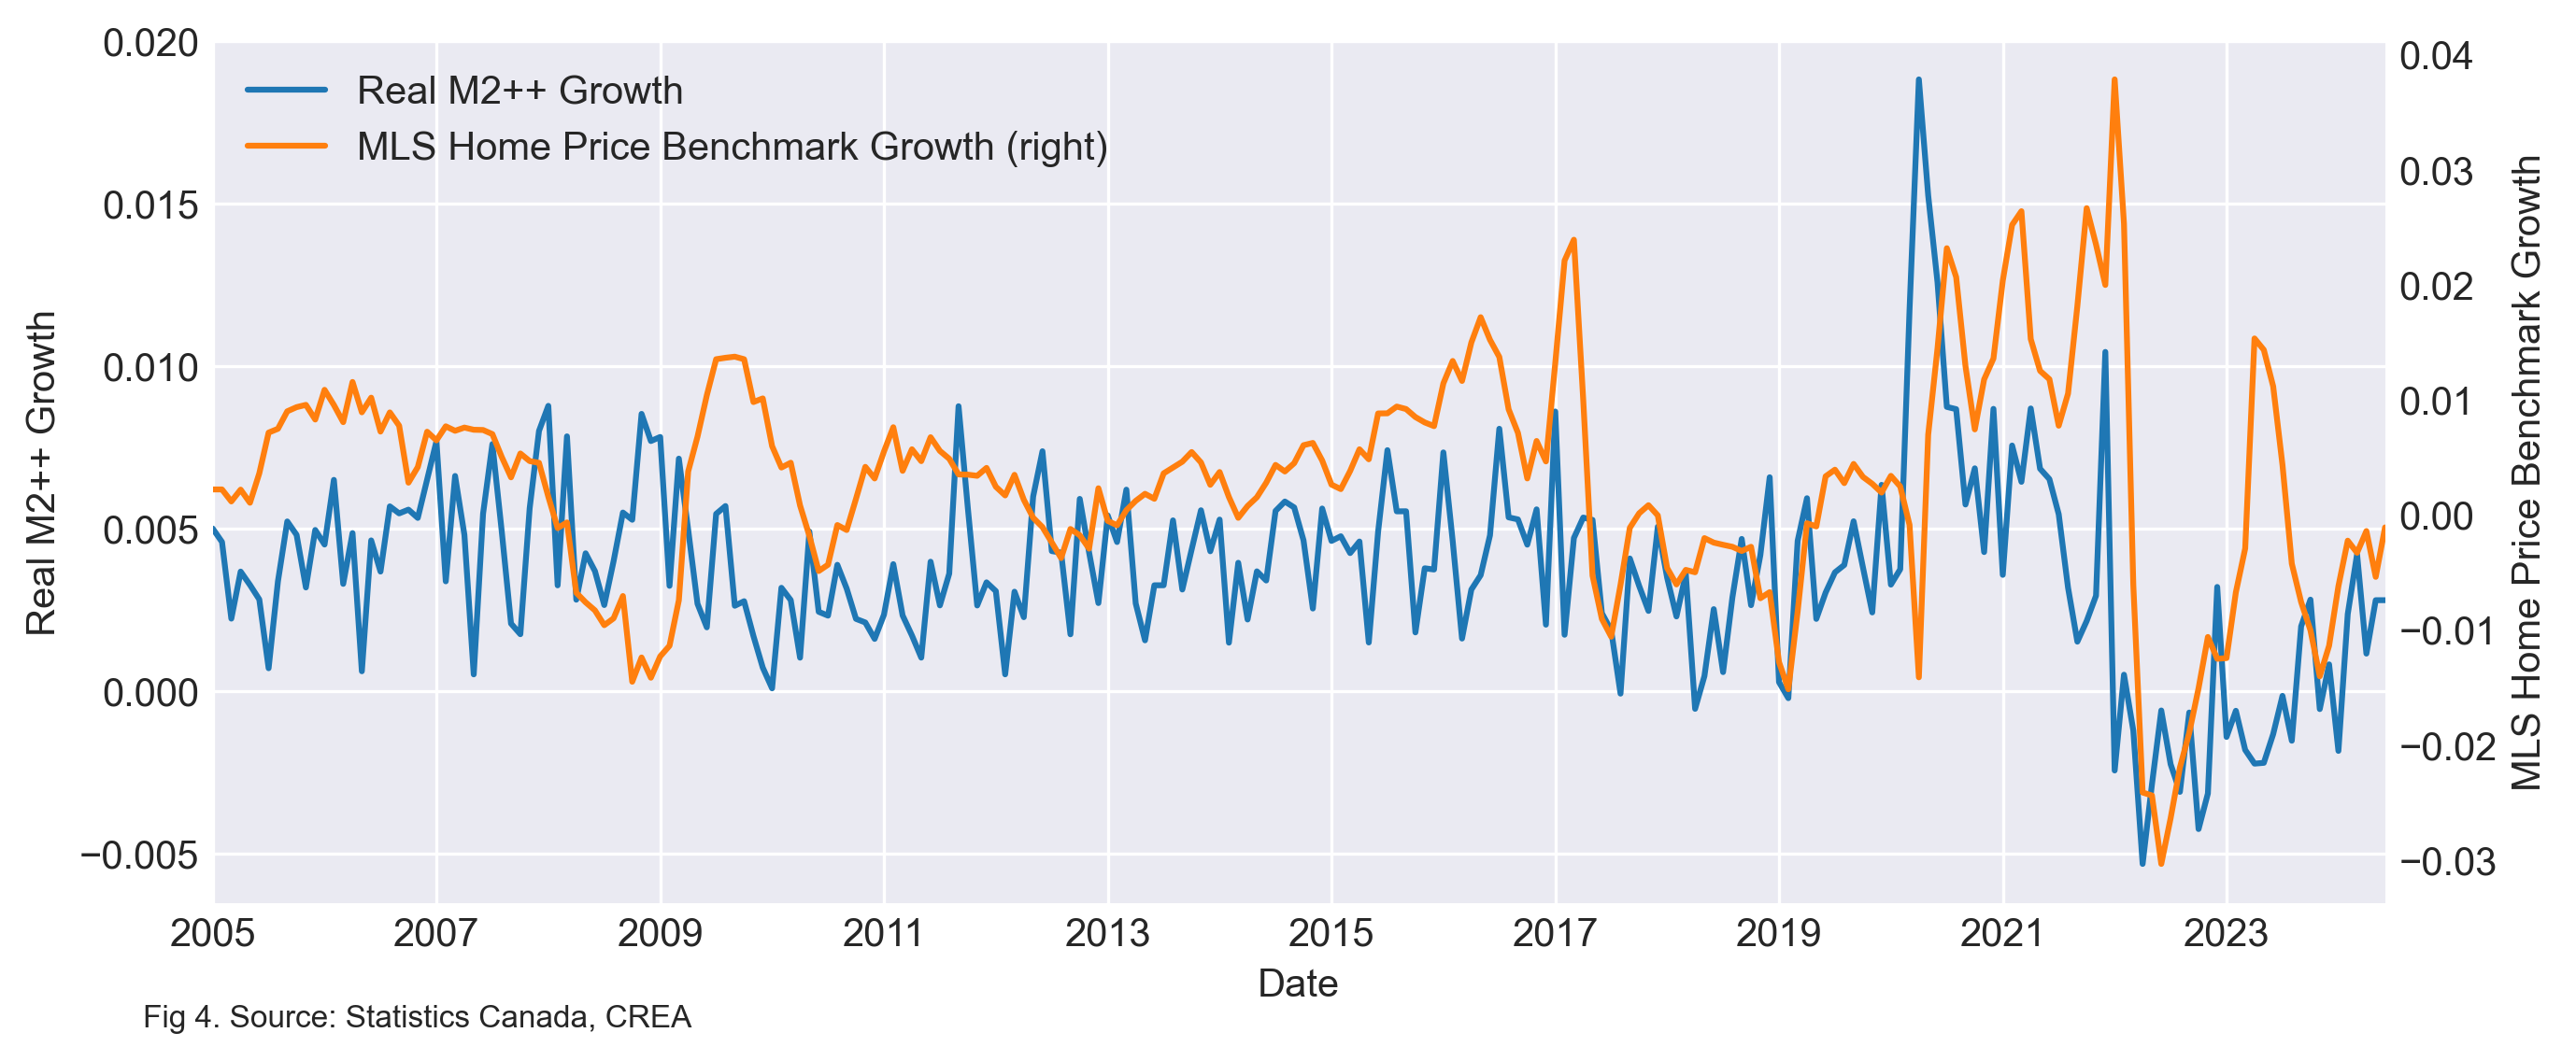

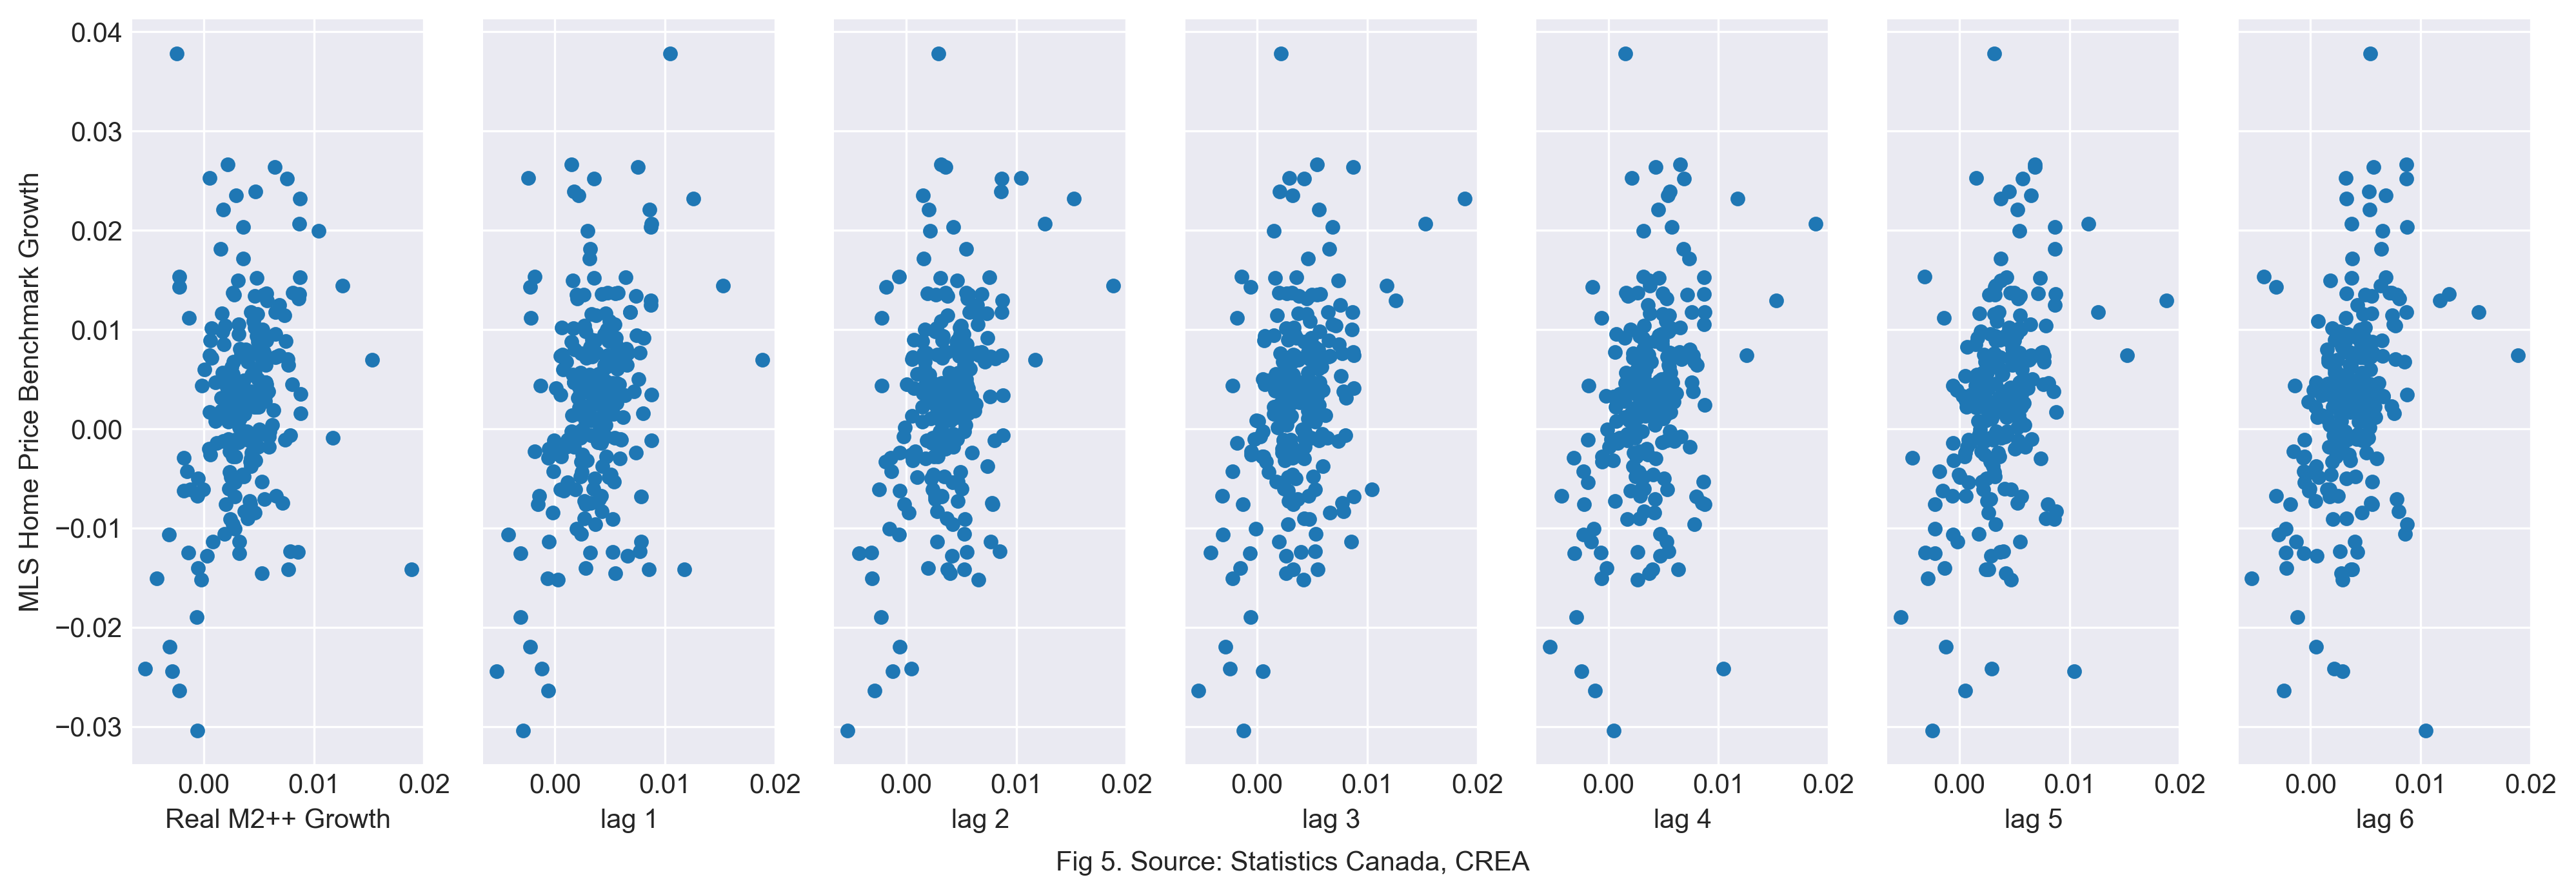

In [11]:
# ["Mortgage rate 5y_growth12_lag_6", "M2++_growth12_real_lag_6"]
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':300})

fig, ax = plt.subplots()
df_cov["Sales"][pd.Timestamp("20061225"):].plot(label="Monthly Home Sales", ylabel="Monthly Home Sales", ax=ax, legend="left")
df_cov[target][pd.Timestamp("20061225"):].plot(secondary_y=True, label="MLS Home Price Benchmark Growth", ylabel="MLS Home Price Benchmark Growth", ax=ax, legend="left")
plt.figtext(0.1, 0, "Fig 1. Source: CREA", wrap=True, fontsize=8)
plt.savefig("plots/sales.png")

fig, ax = plt.subplots()
df_cov["Mortgage rate 5y_growth12"].plot(label="Annual 5-Year Mortgage Rate Growth", ylabel="Annual 5-Year Mortgage Rate Growth", ax=ax, legend="left")
df_cov[target].plot(secondary_y=True, label="MLS Home Price Benchmark Growth", ylabel="MLS Home Price Benchmark Growth", ax=ax, legend="left")
plt.figtext(0.1, 0, "Fig 2. Source: Statistics Canada, CREA", wrap=True, fontsize=8)
plt.savefig("plots/rates_ts.png")


feature = "Mortgage rate 5y_growth12"
fig, ax = plt.subplots(1, 7, sharey="row",  figsize=(16,5))
for j in range(7):
    col_name  = feature if j==0 else feature + "_lag_" + str(j)
    if col_name in df_cov.columns:
        df_cov.plot.scatter(col_name, target, ax=ax[j])
        ax[j].set_xlabel("Annual 5-Year Mortgage Rate Growth" if j==0 else "lag " + str(j))
        ax[j].set_ylabel("MLS Home Price Benchmark Growth")
plt.figtext(0.5, 0, "Fig 3. Source: Statistics Canada, CREA", wrap=True, horizontalalignment='center',  fontsize=10)
plt.savefig("plots/rates_scatter.png")

fig, ax = plt.subplots()
df_cov["M2++_growth1_real"].plot(label="Real M2++ Growth", ylabel="Real M2++ Growth", ax=ax, legend="left")
df_cov[target].plot(secondary_y=True, label="MLS Home Price Benchmark Growth", ylabel="MLS Home Price Benchmark Growth", ax=ax, legend="left")
plt.figtext(0.1, 0, "Fig 4. Source: Statistics Canada, CREA", wrap=True, fontsize=8)
plt.savefig("plots/m2_ts.png")

feature = "M2++_growth1_real"
fig, ax = plt.subplots(1, 7, sharey="row", figsize=(16,5))
for j in range(7):
    col_name  = feature if j==0 else feature + "_lag_" + str(j)
    if col_name in df_cov.columns:
        df_cov.plot.scatter(col_name, target, ax=ax[j])
        ax[j].set_xlabel("Real M2++ Growth" if j==0 else "lag " + str(j))
        ax[j].set_ylabel("MLS Home Price Benchmark Growth")
plt.figtext(0.5, 0, "Fig 5. Source: Statistics Canada, CREA", wrap=True, horizontalalignment='center',  fontsize=10)
plt.savefig("plots/m2_scatter.png")
